In [34]:
import pandas as pd
import numpy as np
import os
import json
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from scipy import stats

from sklearn.metrics import r2_score
import scipy.stats as stats



In [35]:
PROMPT_VERSIONS = 3
QUESTION_INDICES = [0,1,2,3,4]
LLM_VERSION = "gpt-oss"  # Change this to the desired LLM name
REPETITIONS = 5


QUESTIONS = [
    "Auf allen Deutschen Autobahnen soll es ein generelles Tempolimit geben",
    "Deutschland soll seine Verteidigungsausgaben erhöhen",
    "Bei Bundestagswahlen sollen auch Jugendliche ab 16 Jahren wählen dürfen.",
    "Die Förderung von Windenergie soll beendet werden.",
    "Die Möglichkeiten der Vermieterinnen und Vermieter, Wohnungsmieten zu erhöhen, sollen gesetzlich stärker begrenzt werden.",
]

QUESTIONS_EN = [
    'A general speed limit should apply on all motorways.',
    'Germany should increase its defence spending.',
    'Young people aged 16 and over should also be allowed to vote in federal elections.',
    'The promotion of wind energy should be ended.',
    'The ability of landlords to increase rents should be more strictly limited by law.',
]

QUESTIONS_SHORT = [
    "Tempolimit",
    "Verteidigungsausgaben",
    "Wahlrecht ab 16",      
    "Windenergie",
    "Mietpreisbremse",
]

QUESTIONS_SHORT_EN = [
    "Speed limit",
    "Defense spending",
    "Voting age 16",
    "Wind energy",
    "Rent control",
]

In [36]:
notebook_path = os.getcwd()
all_answers_versions = pd.DataFrame()

for question_index in QUESTION_INDICES:

    config_path = os.path.join(notebook_path, f"../config_merged/question_{question_index}")
    print(config_path)
    # get name of all subdirectories in ../configs
    subdirs = [
        d
        for d in os.listdir(config_path)
        if os.path.isdir(os.path.join(config_path, d))
    ]
    for subdir in subdirs:
        subdir_path = os.path.join(config_path, subdir)
        for v in range(PROMPT_VERSIONS ):
            for repetition in range(REPETITIONS):
                config_file = os.path.join(subdir_path, f"config_{repetition}.json")
                try:
                    with open(config_file, "r") as file:
                        config_data = json.load(file)
                    config_df = pd.json_normalize(config_data)
                    party_1 = config_df["persons"][0][0]["party"]
                    party_2 = config_df["persons"][0][1]["party"]
                    name_1 = config_df["persons"][0][0]["name"]
                    name_2 = config_df["persons"][0][1]["name"]
                except Exception as e:
                    print(f"Error reading {config_file}: {e}")
                    continue

                json_file = os.path.join(
                    subdir_path, f"out_{LLM_VERSION}_v{v}_{repetition}.json"
                )

                try:
                    with open(json_file, "r") as file:
                        data = json.load(file)
                except Exception as e:
                    print(f"Error reading {json_file}: {e}")
                    continue
                columns = {}
                columns["question_index"] = question_index
                columns["party_1"] = party_1
                columns["party_2"] = party_2
                columns["repetition"] = repetition
                columns["version"] = v
                for q in data["survey_question"]:
                    actual_name = q["chat_entry"]["entity"]["name"]
                    name = "agent_1" if actual_name == name_1 else "agent_2"
                    iteration = q["iteration"]
                    col_name = f"{name}_T{iteration}"
                    columns[col_name] = q["chat_entry"]["answer"]
                answers_df = pd.DataFrame([columns])

                all_answers_versions = pd.concat([all_answers_versions, answers_df], ignore_index=True)


display(all_answers_versions)

print(f"length of all_answers_versions: {len(all_answers_versions)}")


/Users/lawrencefulton/Documents/MA/SAUCE/analyze/../config_merged/question_0
/Users/lawrencefulton/Documents/MA/SAUCE/analyze/../config_merged/question_1
/Users/lawrencefulton/Documents/MA/SAUCE/analyze/../config_merged/question_2
/Users/lawrencefulton/Documents/MA/SAUCE/analyze/../config_merged/question_3
/Users/lawrencefulton/Documents/MA/SAUCE/analyze/../config_merged/question_4


,question_index,party_1,party_2,repetition,version,agent_1_T0,agent_2_T0,agent_1_T4,agent_2_T4,agent_1_T8,agent_2_T8,agent_1_T12,agent_2_T12,agent_1_T16,agent_2_T16,agent_1_T20,agent_2_T20
0,0,CDU/CSU,AfD,0,0,5,2,5,5,5,5,5,5,5,5,5,5
1,0,CDU/CSU,AfD,1,0,3,5,4,5,5,5,6,6,6,5,5,5
2,0,CDU/CSU,AfD,2,0,5,4,5,5,5,5,5,5,5,5,5,5
3,0,CDU/CSU,AfD,3,0,5,5,5,5,5,5,5,5,5,5,5,4
4,0,CDU/CSU,AfD,4,0,5,5,5,5,5,5,5,5,5,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,4,FDP,CDU/CSU,0,2,6,5,5,5,6,5,6,5,5,5,5,5
2096,4,FDP,CDU/CSU,1,2,6,6,6,5,6,5,6,5,6,5,6,5
2097,4,FDP,CDU/CSU,2,2,6,5,6,4,6,4,6,4,6,4,5,5
2098,4,FDP,CDU/CSU,3,2,6,5,5,4,5,4,6,4,6,5,6,5


length of all_answers_versions: 2100


In [37]:
# cahnge 'keine Partei' to 'Default'
all_answers_versions = all_answers_versions.replace("keine Partei", "Default")
display(all_answers_versions)

,question_index,party_1,party_2,repetition,version,agent_1_T0,agent_2_T0,agent_1_T4,agent_2_T4,agent_1_T8,agent_2_T8,agent_1_T12,agent_2_T12,agent_1_T16,agent_2_T16,agent_1_T20,agent_2_T20
0,0,CDU/CSU,AfD,0,0,5,2,5,5,5,5,5,5,5,5,5,5
1,0,CDU/CSU,AfD,1,0,3,5,4,5,5,5,6,6,6,5,5,5
2,0,CDU/CSU,AfD,2,0,5,4,5,5,5,5,5,5,5,5,5,5
3,0,CDU/CSU,AfD,3,0,5,5,5,5,5,5,5,5,5,5,5,4
4,0,CDU/CSU,AfD,4,0,5,5,5,5,5,5,5,5,5,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,4,FDP,CDU/CSU,0,2,6,5,5,5,6,5,6,5,5,5,5,5
2096,4,FDP,CDU/CSU,1,2,6,6,6,5,6,5,6,5,6,5,6,5
2097,4,FDP,CDU/CSU,2,2,6,5,6,4,6,4,6,4,6,4,5,5
2098,4,FDP,CDU/CSU,3,2,6,5,5,4,5,4,6,4,6,5,6,5


In [38]:
# of prompts = 3
# of questions = 5
# of repetitions = 5
# of LLM versions = 1
# of party combinations = 28 
# of total rows = 3 * 5 * 5 * 1 * 28 = 2100
print(f"Expected number of rows: {PROMPT_VERSIONS * len(QUESTION_INDICES) * REPETITIONS * 1 * 28}")
print(f"{PROMPT_VERSIONS} * {len(QUESTION_INDICES)} * {REPETITIONS} * 1 * 28 = {PROMPT_VERSIONS * len(QUESTION_INDICES) * REPETITIONS * 1 * 28}")

Expected number of rows: 2100
3 * 5 * 5 * 1 * 28 = 2100


In [39]:
# Helper function to process big_df into long format with agent_idx
def process_big_df(big_df: pd.DataFrame) -> pd.DataFrame:
    t_row = ["party", "debate_with", "repetition"]
    formatted_df = pd.DataFrame(columns=t_row)
    for row in big_df.iterrows():
        party_1 = row[1]["party_1"]
        party_2 = row[1]["party_2"]
        version = int(row[1]["version"])
        repetition = int(row[1]["repetition"])
        question_index = int(row[1]["question_index"])

        # agent_1 row
        agent_1_data = row[1].filter(like="agent_1")
        agent_1_data.index = agent_1_data.index.str.replace("agent_1_", "")
        agent_1_data = agent_1_data.rename(party_1)
        agent_1_data = agent_1_data.to_frame().T
        agent_1_data.insert(0, "debate_with", party_2)
        agent_1_data.insert(0, "party", party_1)
        agent_1_data.insert(0, "repetition", repetition)
        agent_1_data.insert(0, "version", version)
        agent_1_data.insert(0, "question_index", question_index)
        formatted_df = pd.concat([formatted_df, agent_1_data], ignore_index=True)


        if party_1 == party_2:
            # If both agents are the same, we only need one row
            continue


        # agent_2 row
        agent_2_data = row[1].filter(like="agent_2")
        agent_2_data.index = agent_2_data.index.str.replace("agent_2_", "")
        agent_2_data = agent_2_data.rename(party_2)
        agent_2_data = agent_2_data.to_frame().T
        agent_2_data.insert(0, "debate_with", party_1)
        agent_2_data.insert(0, "party", party_2)
        agent_2_data.insert(0, "repetition", repetition)
        agent_2_data.insert(0, "version", version)
        agent_2_data.insert(0, "question_index", question_index)
        formatted_df = pd.concat([formatted_df, agent_2_data], ignore_index=True)
    
    formatted_df = formatted_df.reset_index(drop=True)
    for col in formatted_df.columns:
        if col.startswith("T"):

            def extract_number(text):
                if pd.isna(text):
                    return None
                if isinstance(text, (int, float)):
                    return text
                text = str(text)
                numbers = re.findall(r"\d+", text)
                if numbers:
                    return int(numbers[0])
                else:
                    return None

            formatted_df[col] = formatted_df[col].apply(extract_number)

    

    return formatted_df


formatted_df = process_big_df(all_answers_versions)
display(formatted_df)

,party,debate_with,repetition,question_index,version,T0,T4,T8,T12,T16,T20
0,CDU/CSU,AfD,0,0.0,0.0,5.0,5.0,5.0,5.0,5.0,5.0
1,AfD,CDU/CSU,0,0.0,0.0,2.0,5.0,5.0,5.0,5.0,5.0
2,CDU/CSU,AfD,1,0.0,0.0,3.0,4.0,5.0,6.0,6.0,5.0
3,AfD,CDU/CSU,1,0.0,0.0,5.0,5.0,5.0,6.0,5.0,5.0
4,CDU/CSU,AfD,2,0.0,0.0,5.0,5.0,5.0,5.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...
3670,CDU/CSU,FDP,2,4.0,2.0,5.0,4.0,4.0,4.0,4.0,5.0
3671,FDP,CDU/CSU,3,4.0,2.0,6.0,5.0,5.0,6.0,6.0,6.0
3672,CDU/CSU,FDP,3,4.0,2.0,5.0,4.0,4.0,4.0,5.0,5.0
3673,FDP,CDU/CSU,4,4.0,2.0,5.0,6.0,5.0,6.0,5.0,5.0


In [40]:
formatted_df_non_abs = formatted_df.copy()
party_df_non_abs = formatted_df_non_abs.melt(
    id_vars=["party", "debate_with", "version", "question_index", "repetition"],
    var_name="time",
    value_name="answer",
)
party_df_non_abs = party_df_non_abs.dropna(subset=["answer"]).reset_index(drop=True)
display(party_df_non_abs)

# save as csv
party_df_non_abs.to_csv("party_df_non_abs.csv", index=False)    



,party,debate_with,version,question_index,repetition,time,answer
0,CDU/CSU,AfD,0.0,0.0,0,T0,5.0
1,AfD,CDU/CSU,0.0,0.0,0,T0,2.0
2,CDU/CSU,AfD,0.0,0.0,1,T0,3.0
3,AfD,CDU/CSU,0.0,0.0,1,T0,5.0
4,CDU/CSU,AfD,0.0,0.0,2,T0,5.0
...,...,...,...,...,...,...,...
22002,CDU/CSU,FDP,2.0,4.0,2,T20,5.0
22003,FDP,CDU/CSU,2.0,4.0,3,T20,6.0
22004,CDU/CSU,FDP,2.0,4.0,3,T20,5.0
22005,FDP,CDU/CSU,2.0,4.0,4,T20,5.0


QUESION_INDICES: [0 1 2 3 4]   
Plotting question index 0
Plotting question index 1
Plotting question index 2
Plotting question index 3
Plotting question index 4


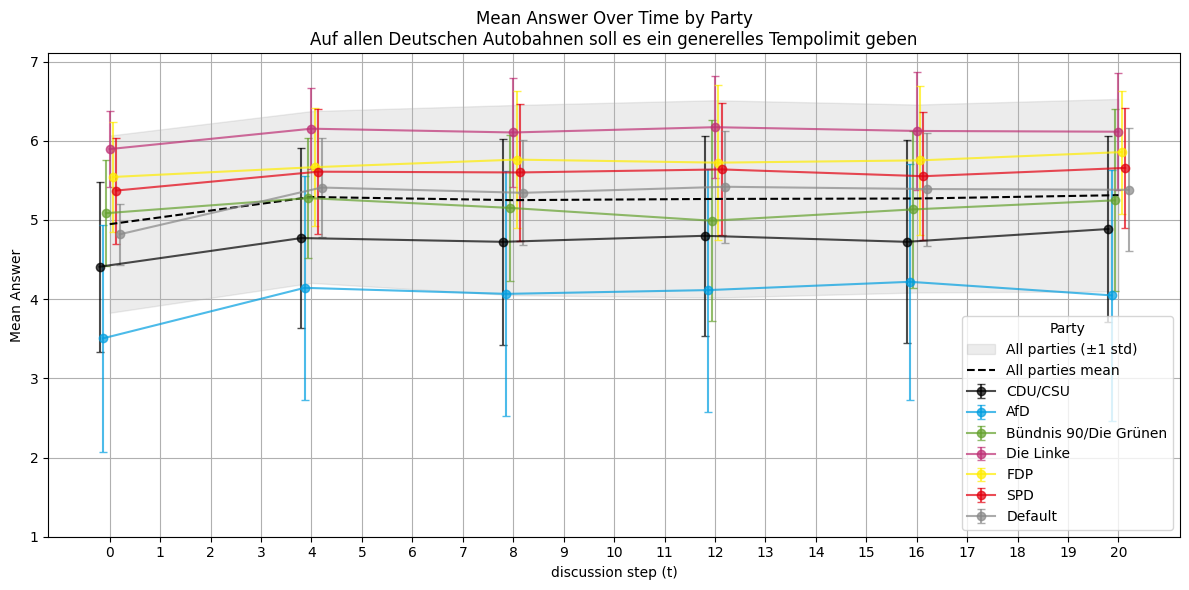

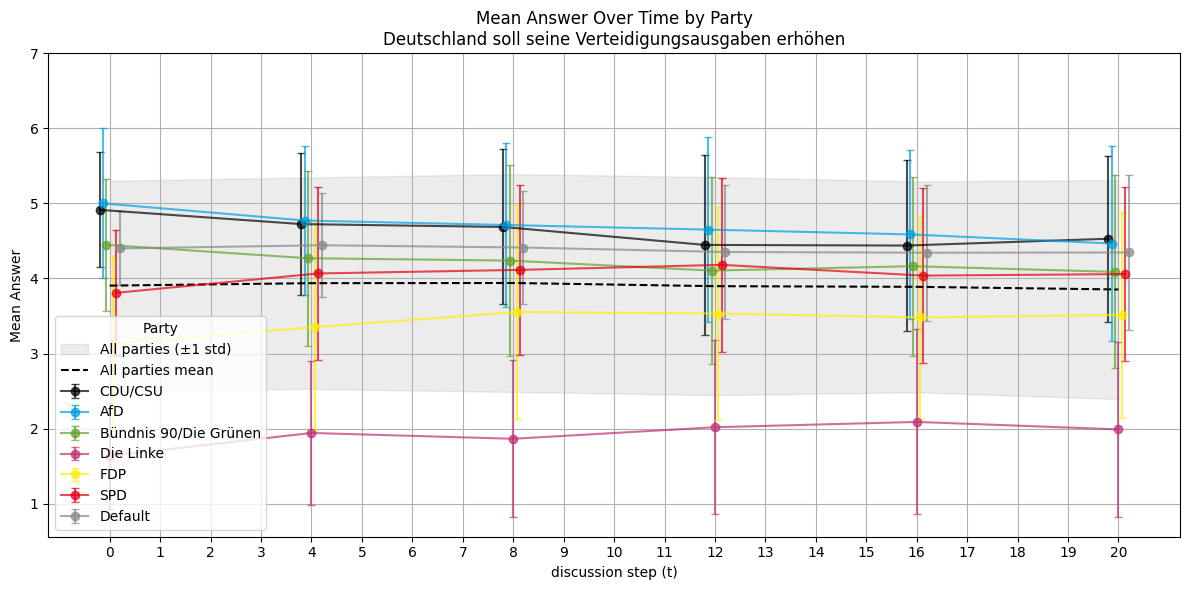

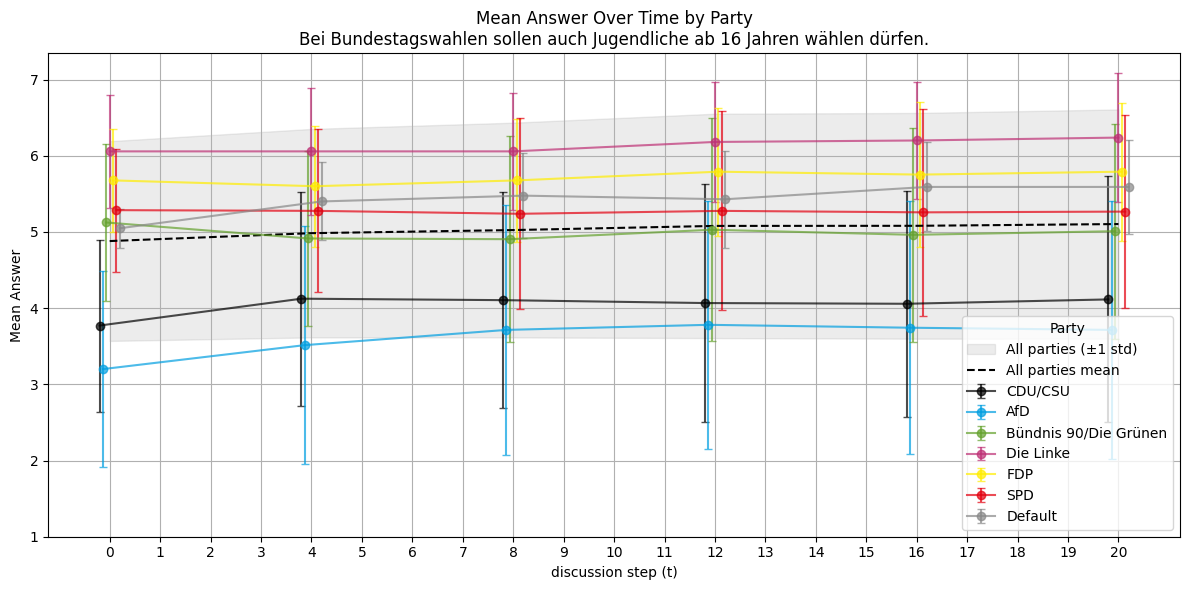

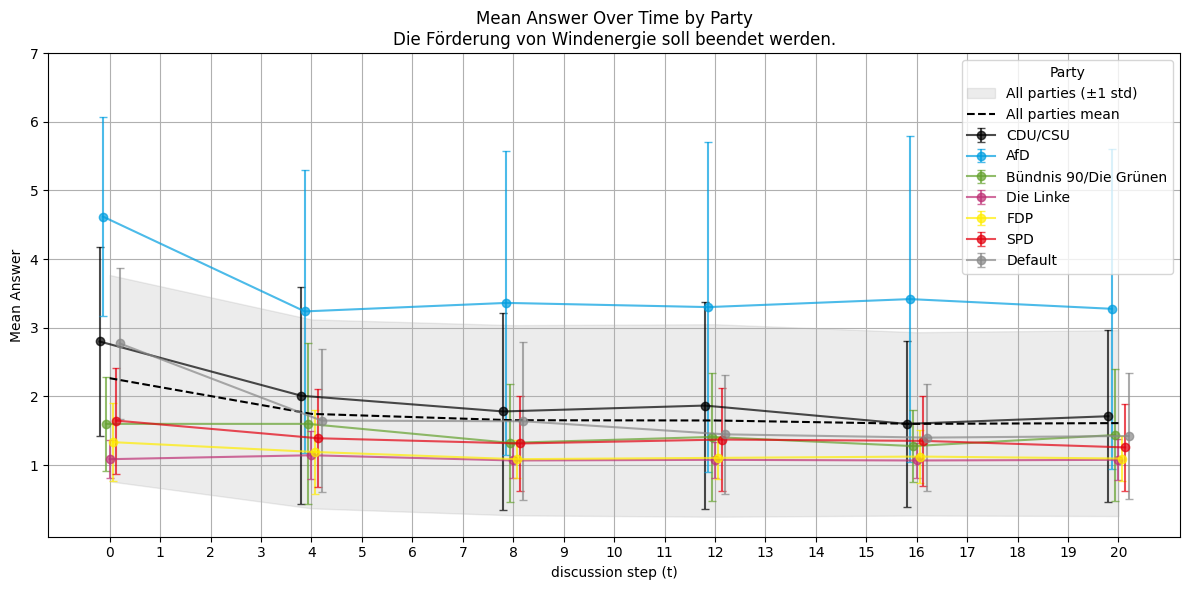

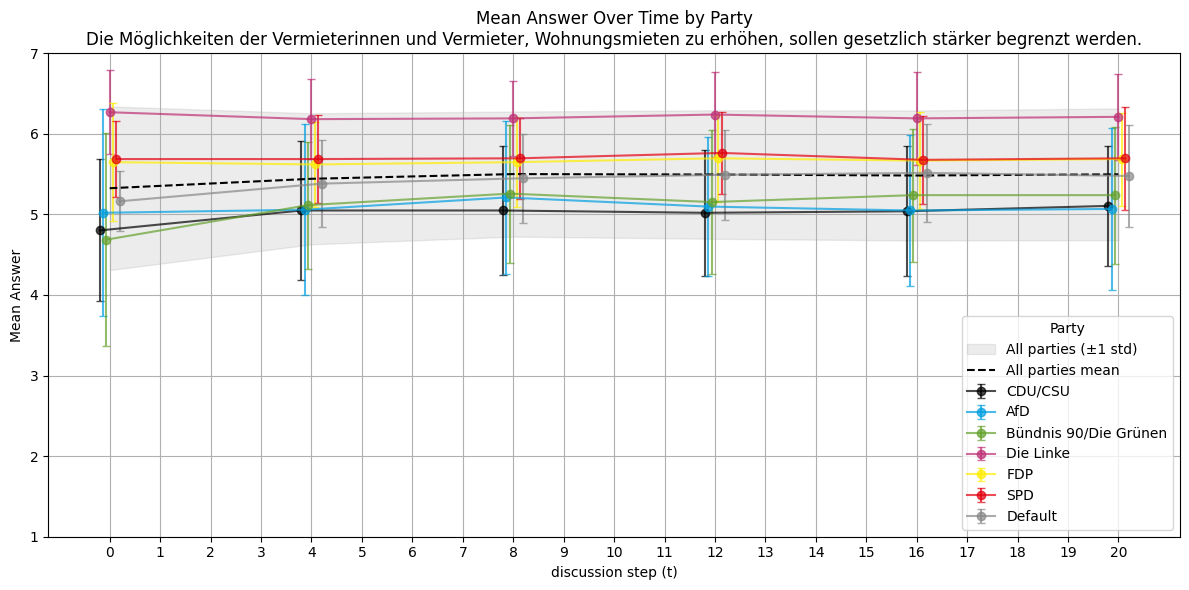

In [41]:
plot_df = party_df_non_abs.copy()



color_map = {
    "CDU/CSU": "#000000",  # Black
    "SPD": "#E3000F",      # Red
    "Bündnis 90/Die Grünen": "#64A12D",  # Green
    "FDP": "#FFED00",      # Yellow
    "Die Linke": "#BE3075", # Dark Pink
    "AfD": "#009EE0",      # Blue
    "Default": "#888888", # Gray
}
    

plot_df["time"] = plot_df["time"].str.replace("T", "").astype(int)
plot_df["question_index"] = plot_df["question_index"].astype(int)
plot_df["repetition"] = plot_df["repetition"].astype(int)
plot_df = plot_df[(plot_df["answer"] <= 7) & (plot_df["answer"] >= 1)]
plot_df["answer"] = pd.to_numeric(plot_df["answer"], errors="coerce")

parties = list(plot_df["party"].unique())
offsets = np.linspace(-0.2, 0.2, len(parties))  # For party errorbars

print(f"QUESION_INDICES: {plot_df["question_index"].unique()}   ")

for question in plot_df["question_index"].unique():
    print(f"Plotting question index {question}")
    plt.figure(figsize=(12, 6))
    # Plot per-party errorbars, slightly offset
    for i, prompts in enumerate(parties):
        prompt_data = plot_df[
            (plot_df["party"] == prompts) & (plot_df["question_index"] == question)
        ]
        means = prompt_data.groupby("time")["answer"].mean()
        stds = prompt_data.groupby("time")["answer"].std()
        x = means.index + offsets[i]
        plt.errorbar(
            x,
            means.values,
            yerr=stds.values,
            marker="o",
            label=f"{prompts}",
            capsize=3,
            alpha=0.7,
            color=color_map.get(prompts, None),
        )
    # Plot overall mean and std as a field (no offset)
    all_data = plot_df[plot_df["question_index"] == question]
    all_means = all_data.groupby("time")["answer"].mean()
    all_stds = all_data.groupby("time")["answer"].std()
    plt.fill_between(
        all_means.index,
        all_means - all_stds,
        all_means + all_stds,
        color="gray",
        alpha=0.15,
        label="All parties (±1 std)",
    )
    plt.plot(
        all_means.index,
        all_means.values,
        color="black",
        linestyle="--",
        label="All parties mean",
    )
    plt.title(f"Mean Answer Over Time by Party\n{QUESTIONS[question]}")
    plt.xticks(range(0, 21))
    plt.yticks(range(1, 8))
    plt.xlabel("discussion step (t)")
    plt.ylabel("Mean Answer")
    plt.legend(title="Party")
    plt.grid()
    plt.tight_layout()

    if question == 3:
        plt.savefig("figures/normalised_answer_distributions_wind_energy.pdf")

    #plt.show()

[np.float64(0.0), np.float64(1.0), np.float64(2.0)]
QUESION_INDICES: [0 1 2 3 4]   
Plotting question index 0
Plotting question index 1
Plotting question index 2
Plotting question index 3
Plotting question index 4


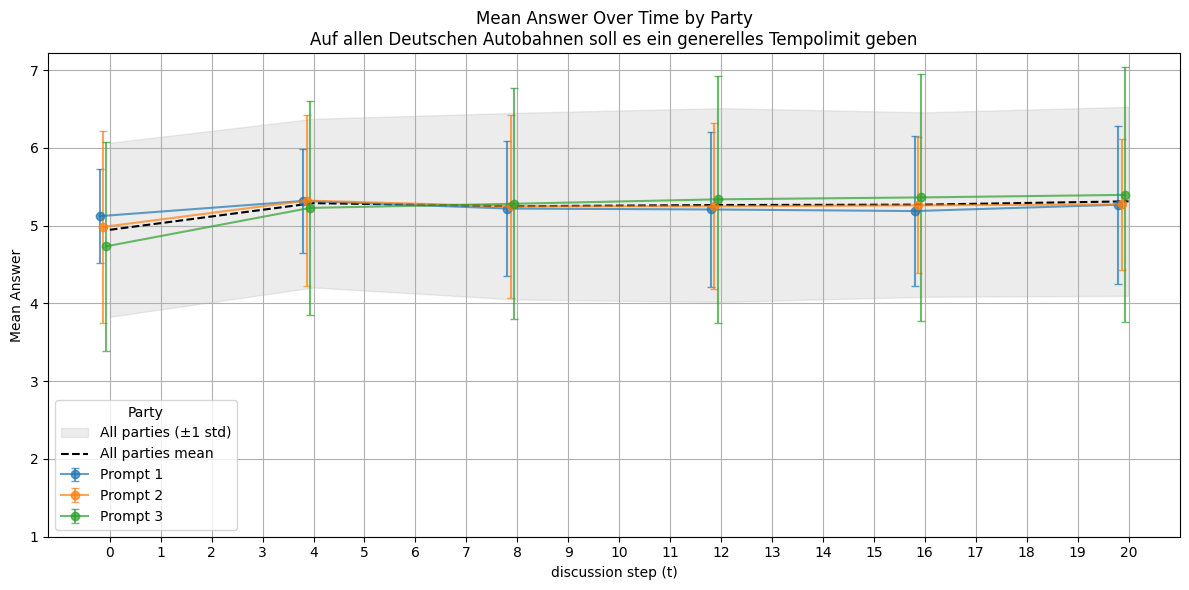

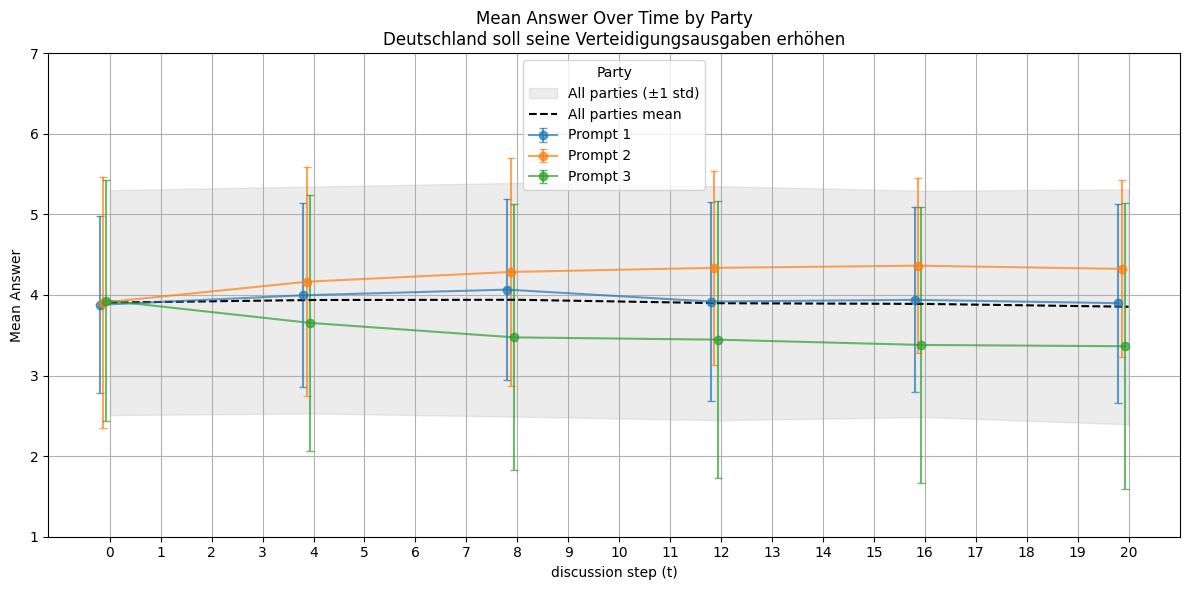

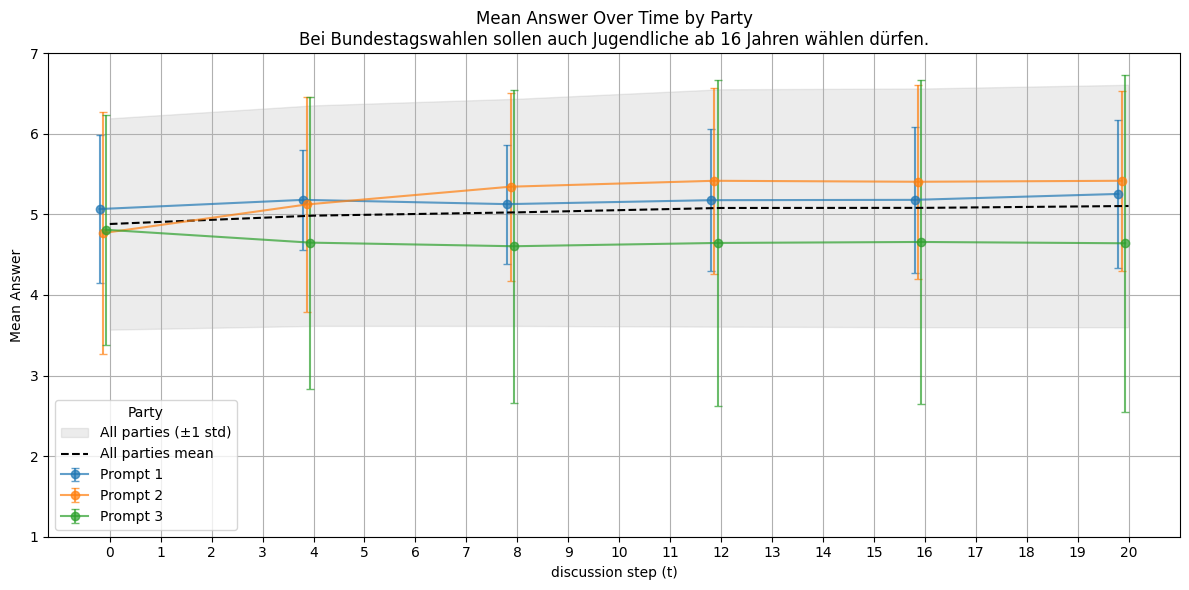

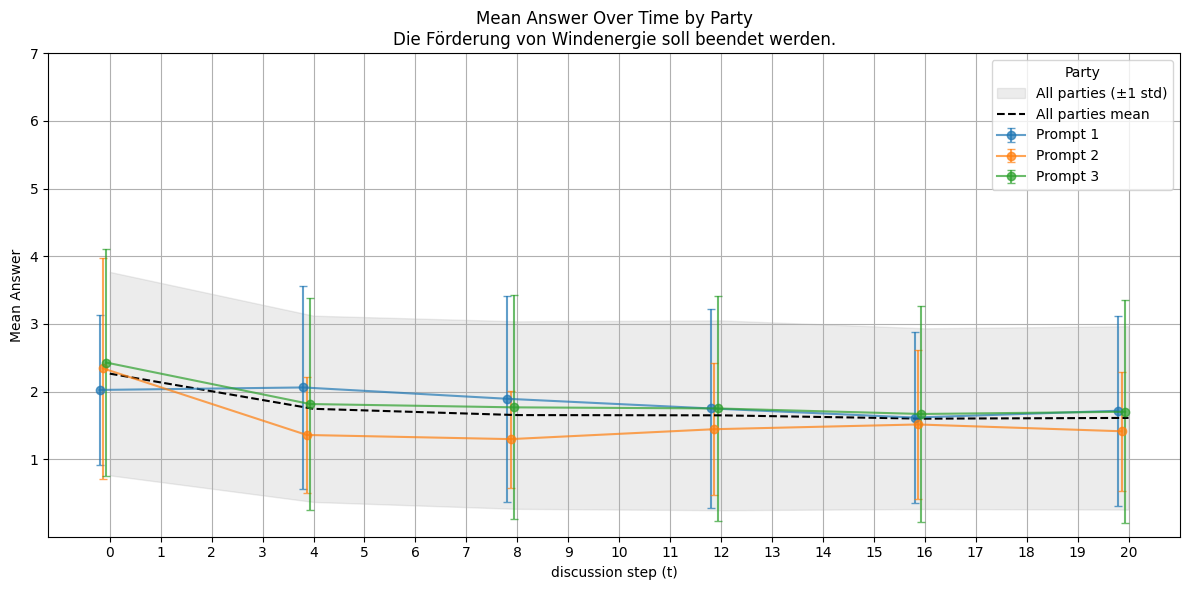

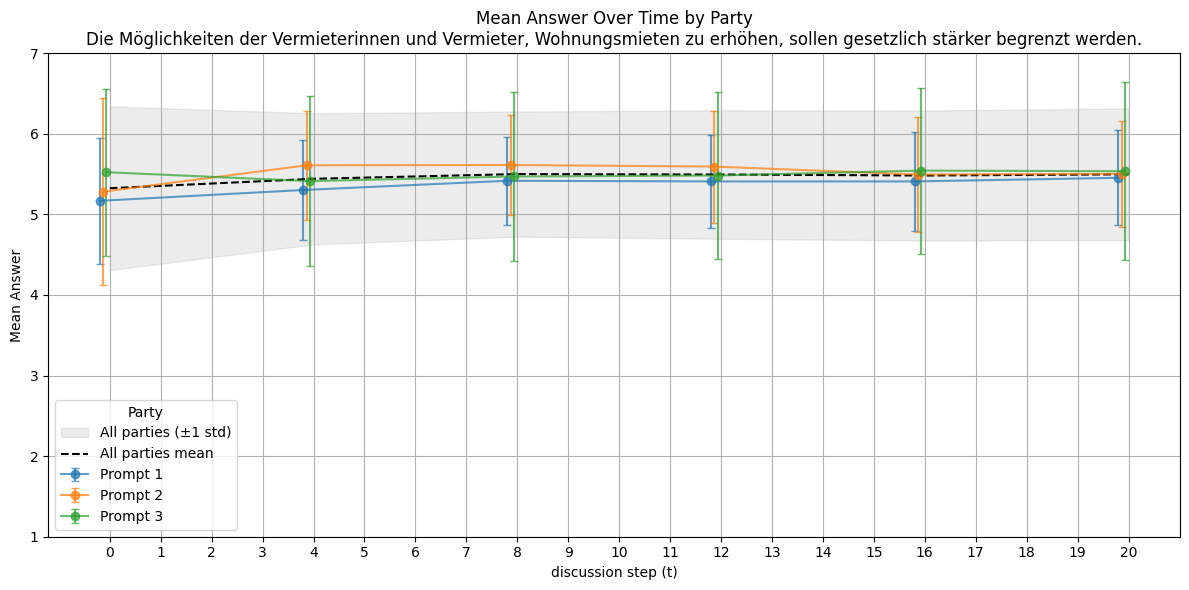

In [42]:
plot_df = party_df_non_abs.copy()

prompt_labels = {
    0: "Prompt 1",
    1: "Prompt 2",
    2: "Prompt 3"
}


    

plot_df["time"] = plot_df["time"].str.replace("T", "").astype(int)
plot_df["question_index"] = plot_df["question_index"].astype(int)
plot_df["repetition"] = plot_df["repetition"].astype(int)
plot_df = plot_df[(plot_df["answer"] <= 7) & (plot_df["answer"] >= 1)]
plot_df["answer"] = pd.to_numeric(plot_df["answer"], errors="coerce")

parties = list(plot_df["party"].unique())
prompts = list(plot_df["version"].unique())
print(prompts)
offsets = np.linspace(-0.2, 0.2, len(parties))  # For party errorbars

print(f"QUESION_INDICES: {plot_df["question_index"].unique()}   ")

for question in plot_df["question_index"].unique():
    print(f"Plotting question index {question}")
    plt.figure(figsize=(12, 6))
    # Plot per-party errorbars, slightly offset
    for i, prompt in enumerate(prompts):
        prompt_data = plot_df[
            (plot_df["version"] == prompt) & (plot_df["question_index"] == question)
        ]
        means = prompt_data.groupby("time")["answer"].mean()
        stds = prompt_data.groupby("time")["answer"].std()
        x = means.index + offsets[i]
        plt.errorbar(
            x,
            means.values,
            yerr=stds.values,
            marker="o",
            label=f"{prompt_labels.get(prompt, prompt)}",
            capsize=3,
            alpha=0.7,
        )
    # Plot overall mean and std as a field (no offset)
    all_data = plot_df[plot_df["question_index"] == question]
    all_means = all_data.groupby("time")["answer"].mean()
    all_stds = all_data.groupby("time")["answer"].std()
    plt.fill_between(
        all_means.index,
        all_means - all_stds,
        all_means + all_stds,
        color="gray",
        alpha=0.15,
        label="All parties (±1 std)",
    )
    plt.plot(
        all_means.index,
        all_means.values,
        color="black",
        linestyle="--",
        label="All parties mean",
    )
    plt.title(f"Mean Answer Over Time by Party\n{QUESTIONS[question]}")
    plt.xticks(range(0, 21))
    plt.yticks(range(1, 8))
    plt.xlabel("discussion step (t)")
    plt.ylabel("Mean Answer")
    plt.legend(title="Party")
    plt.grid()
    plt.tight_layout()

    if question == 3:
        plt.savefig("figures/normalised_answer_distributions_wind_energy.pdf")

    #plt.show()

Plotting for question 0: Auf allen Deutschen Autobahnen soll es ein generelles Tempolimit geben
Plotting for question 1: Deutschland soll seine Verteidigungsausgaben erhöhen
Plotting for question 2: Bei Bundestagswahlen sollen auch Jugendliche ab 16 Jahren wählen dürfen.
Plotting for question 3: Die Förderung von Windenergie soll beendet werden.
Plotting for question 4: Die Möglichkeiten der Vermieterinnen und Vermieter, Wohnungsmieten zu erhöhen, sollen gesetzlich stärker begrenzt werden.


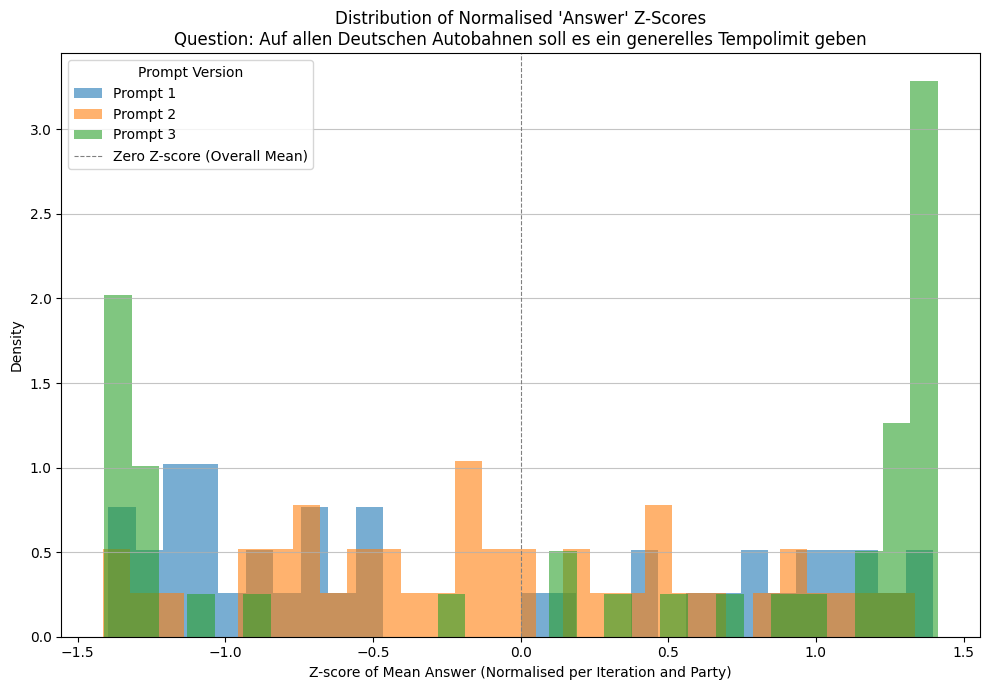

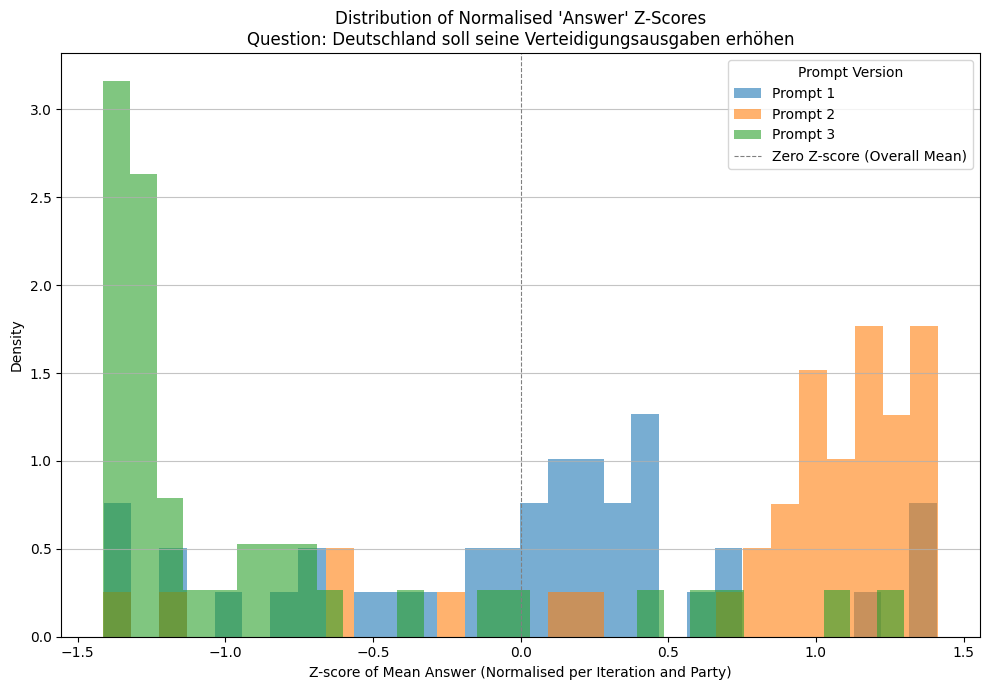

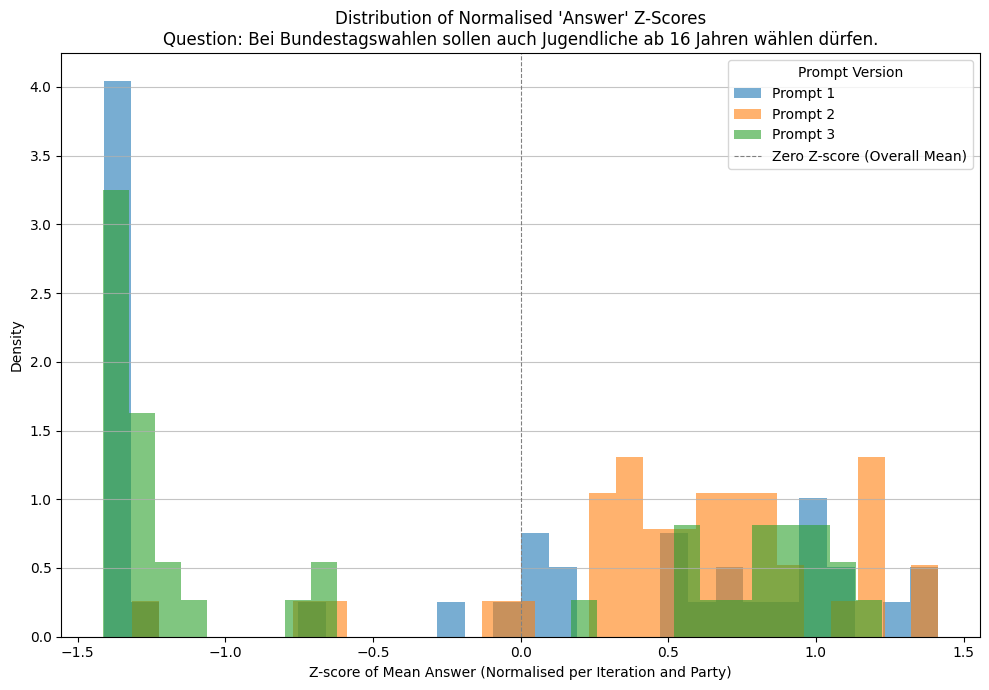

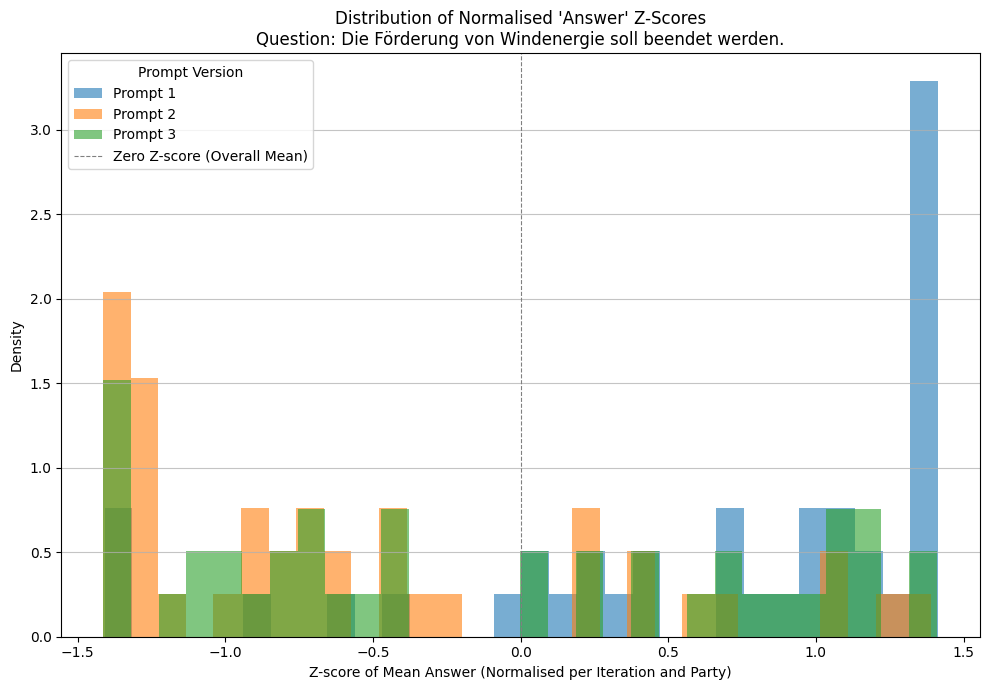

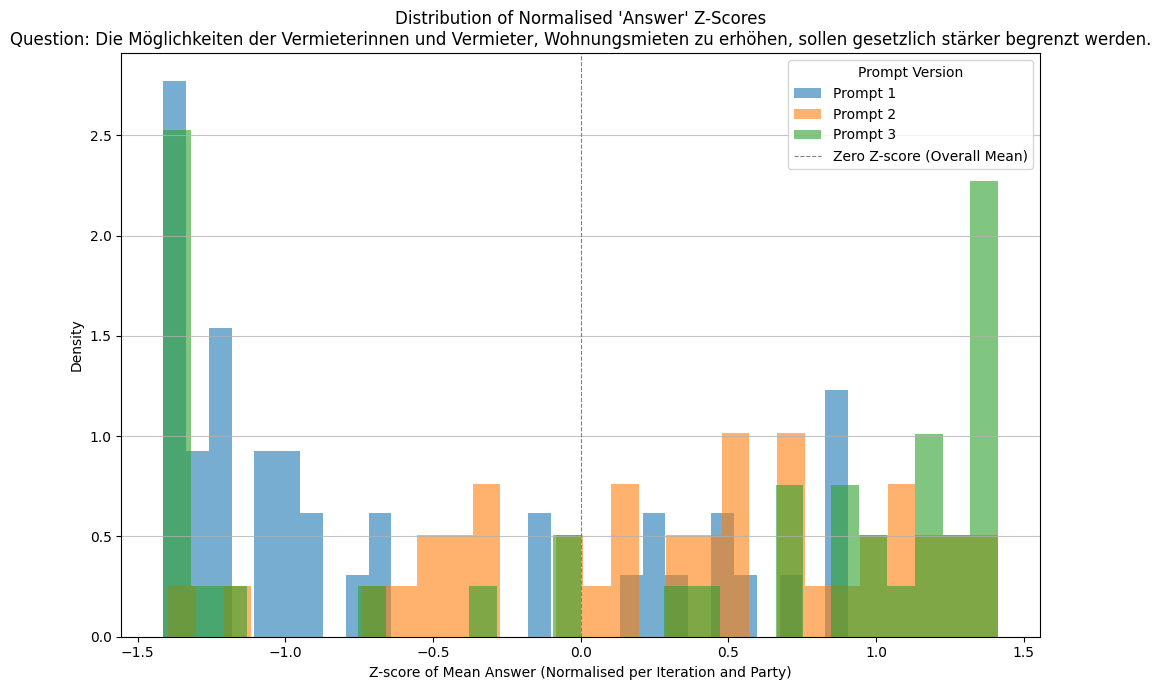

In [43]:
prompt_labels = {
    0: "Prompt 1",
    1: "Prompt 2",
    2: "Prompt 3"
}

for question in plot_df["question_index"].unique():
    print(f"Plotting for question {question}: {QUESTIONS[int(question)]}")

    # Aggregate means per repetition, party, version for this question
    question_data = plot_df[plot_df["question_index"] == question].groupby(
        ["time", "party", "version"]
    )["answer"].mean().reset_index()
    question_data.rename(columns={"answer": "mean_answer"}, inplace=True)

    # Normalise per time and party
    normalised_df = pd.DataFrame()
    for time in question_data["time"].unique():
        for prompts in question_data["party"].unique():
            iteration_data = question_data[
                (question_data["time"] == time)
                & (question_data["party"] == prompts)
            ].copy()
            scaler = StandardScaler()
            iteration_data["z_score"] = scaler.fit_transform(iteration_data[["mean_answer"]])
            normalised_df = pd.concat([normalised_df, iteration_data])

    plt.figure(figsize=(10, 7))
    versions_sorted = sorted(normalised_df["version"].unique())
    for version_str in versions_sorted:
        prompt_v = int(version_str)
        version_data = normalised_df[normalised_df["version"] == version_str]
        plt.hist(
            version_data["z_score"],
            bins=30,
            alpha=0.6,
            label=prompt_labels[prompt_v],
            density=True,
            histtype='stepfilled'
        )
    plt.axvline(0, color='grey', linestyle='--', linewidth=0.8, label='Zero Z-score (Overall Mean)')
    plt.title(f"Distribution of Normalised 'Answer' Z-Scores\nQuestion: {QUESTIONS[int(question)]}")
    plt.xlabel("Z-score of Mean Answer (Normalised per Iteration and Party)")
    plt.ylabel("Density")
    plt.legend(title="Prompt Version")
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()
    #plt.show()


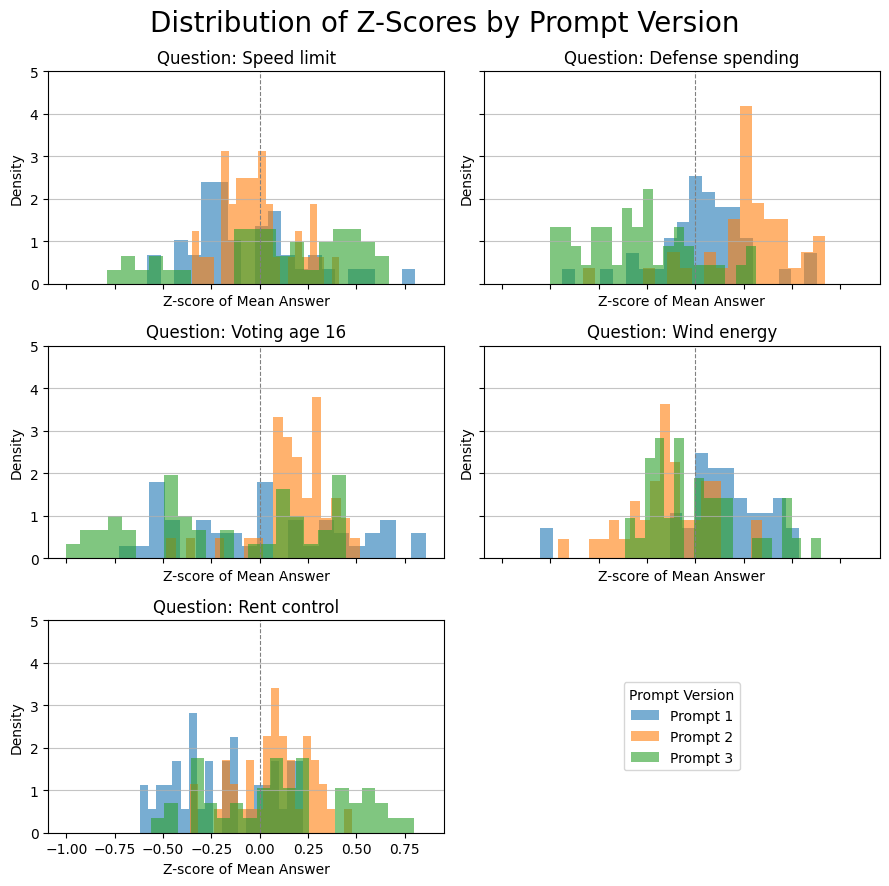

In [44]:
prompt_labels = {
    0: "Prompt 1",
    1: "Prompt 2",
    2: "Prompt 3"
}

fig, axes = plt.subplots(3, 2, figsize=(9, 9), sharex=True, sharey=True)


axes = axes.flatten()

n_questions = len(plot_df["question_index"].unique())

for ax, question in zip(axes, plot_df["question_index"].unique()):
    normalised_df = {0: [], 1: [], 2: []}
    question_data = plot_df[plot_df["question_index"] == question].copy()

    for time in question_data["time"].unique():
        for prompts in question_data["party"].unique():
            iteration_data = question_data[
                 (question_data["time"] == time)
                & (question_data["party"] == prompts)
            ].copy()

            
            scaler = StandardScaler()
            scaler.fit(iteration_data[["answer"]].values.reshape(-1, 1))
            for prompt_v in range(3):
                mean = np.mean(
                    iteration_data[iteration_data["version"] == prompt_v]["answer"]
                )
                z_score = scaler.transform(np.array([[mean]]))[0][0]
                normalised_df[prompt_v].append(z_score)


    versions_sorted = sorted(normalised_df.keys())
    for version_str in versions_sorted:
        prompt_v = version_str
        version_data = normalised_df[prompt_v]
        ax.hist(
            version_data,
            bins=20,
            alpha=0.6,
            label=prompt_labels[prompt_v],
            density=True,
            histtype="stepfilled",
        )

    ax.axvline(0, color='grey', linestyle='--', linewidth=0.8)
    ax.set_title(f"Question: {QUESTIONS_SHORT_EN[int(question)]}")
    ax.set_xlabel("Z-score of Mean Answer")
    ax.set_ylabel("Density")
    ax.set_ylim(0, 5)
    ax.grid(axis='y', alpha=0.75)

if n_questions < len(axes):
    legend_ax = axes[n_questions]
    legend_ax.axis("off")  # hide axis
    handles, labels = axes[0].get_legend_handles_labels()
    legend_ax.legend(handles, labels, title="Prompt Version", loc="center")

# Hide any additional unused axes (in case of fewer than 5)
for ax in axes[n_questions+1:]:
    ax.set_visible(False)


fig.suptitle("Distribution of Z-Scores by Prompt Version", fontsize=20)  
plt.tight_layout(rect=[0, 0, 1, 0.96]) 



plt.tight_layout()
plt.savefig(f"figures/normalised_answer_distributions_{LLM_VERSION}.pdf")
plt.show()


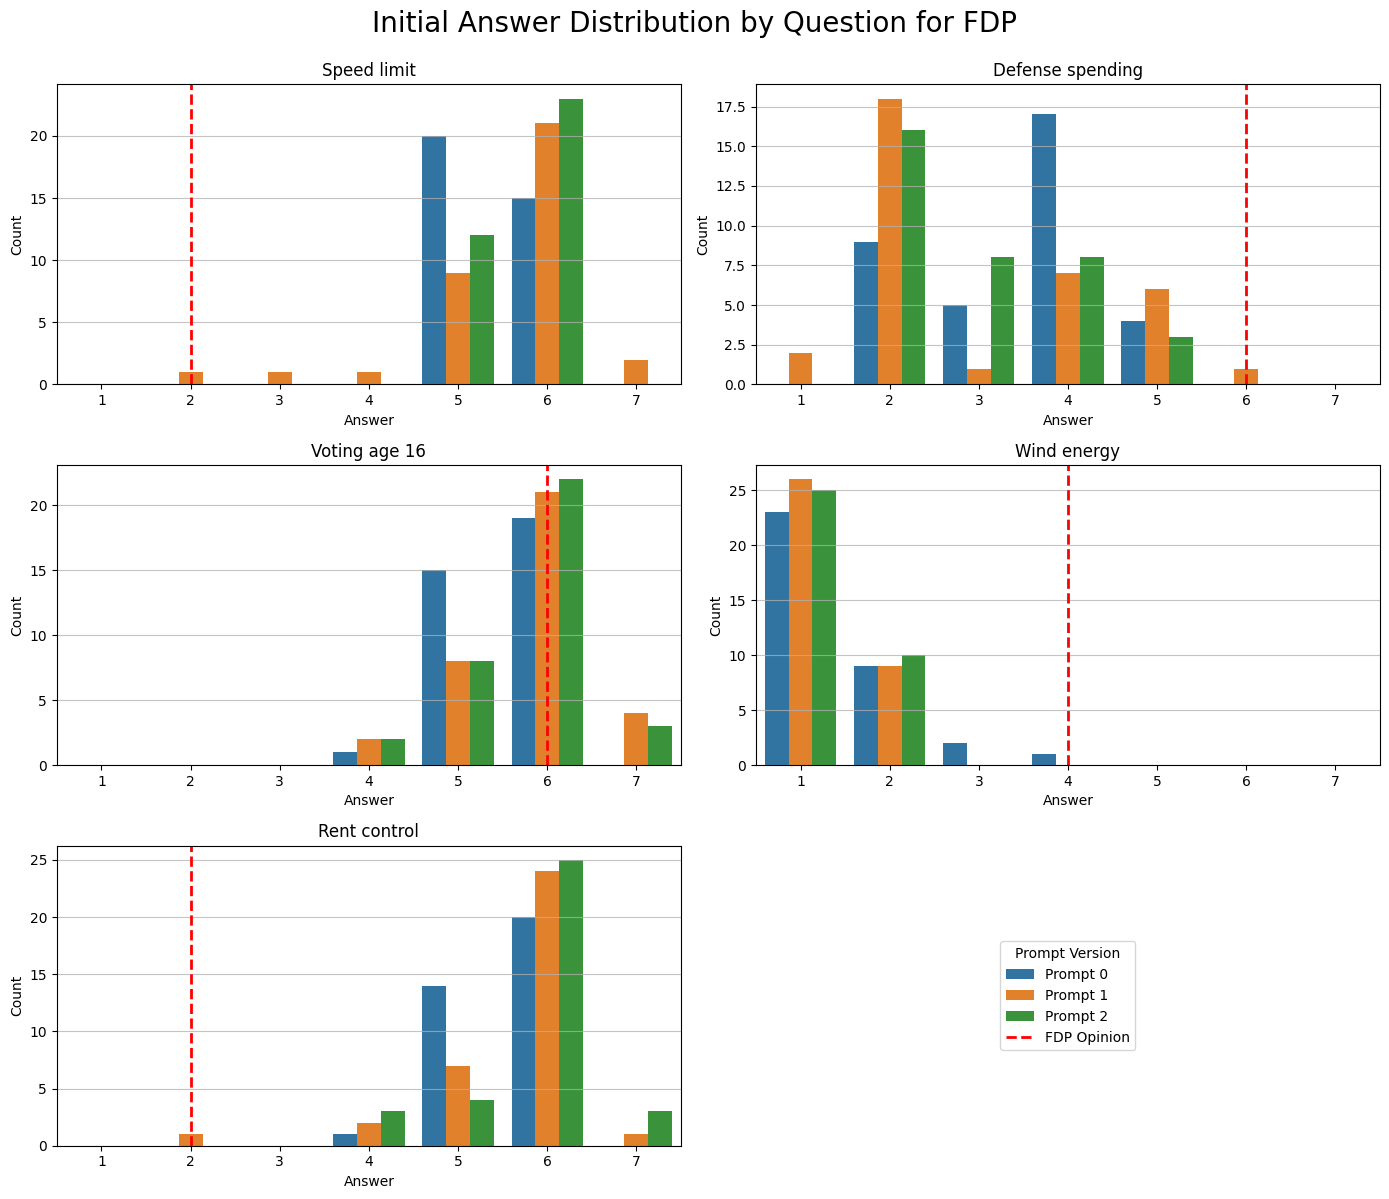

In [45]:
import seaborn as sns

pp = "FDP"
# FDP party opinions: False=1-3, Neutral=4, True=5-7
fdp_opinions = [False, True, True, 'None', False]
# Convert to numeric: False -> 2, Neutral -> 4, True -> 6
opinion_numeric = {False: 2, 'None': 4, True: 6}
fdp_opinions_numeric = [opinion_numeric[op] for op in fdp_opinions]

fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, question_idx in enumerate(range(5)):
    q_df = plot_df[
        (plot_df["question_index"] == question_idx) & (plot_df["party"] == pp) & (plot_df['time'] == 0)
    ].copy()
    
    q_df['answer'] = q_df['answer'].astype(int)
    q_df['prompt'] = q_df['version'].astype(int)
    q_df['prompt'] = q_df['prompt'].apply(lambda x: f"Prompt {x}")
    
    sns.countplot(
        data=q_df,
        x="answer",
        hue="prompt",
        palette="tab10",
        dodge=True,
        hue_order=["Prompt 0", "Prompt 1", "Prompt 2"],
        order=list(range(1, 8)),
        ax=axes[idx]
    )
    
    # Add horizontal line for FDP party opinion
    if fdp_opinions[question_idx] is not None:
        axes[idx].axvline(fdp_opinions_numeric[question_idx] - 1, color='red', linestyle='--', linewidth=2, label='FDP Opinion')
    
    axes[idx].set_title(f"{QUESTIONS_SHORT_EN[question_idx]}", fontsize=12)
    axes[idx].set_xlabel("Answer")
    axes[idx].set_ylabel("Count")
    axes[idx].grid(axis="y", alpha=0.75)
    
    # remove legend for all but first subplot
    axes[idx].get_legend().remove()

# Hide the last unused subplot

if n_questions < len(axes):
    legend_ax = axes[n_questions]
    legend_ax.axis("off")  # hide axis
    handles, labels = axes[0].get_legend_handles_labels()
    legend_ax.legend(handles, labels, title="Prompt Version", loc="center")


for ax in axes[n_questions+1:]:
    ax.set_visible(False)

fig.suptitle(f"Initial Answer Distribution by Question for {pp}", fontsize=20, y=0.995)
plt.tight_layout()
plt.savefig(f"figures/answer_count_distribution_{pp}_all_q_{LLM_VERSION}.pdf")
plt.show()

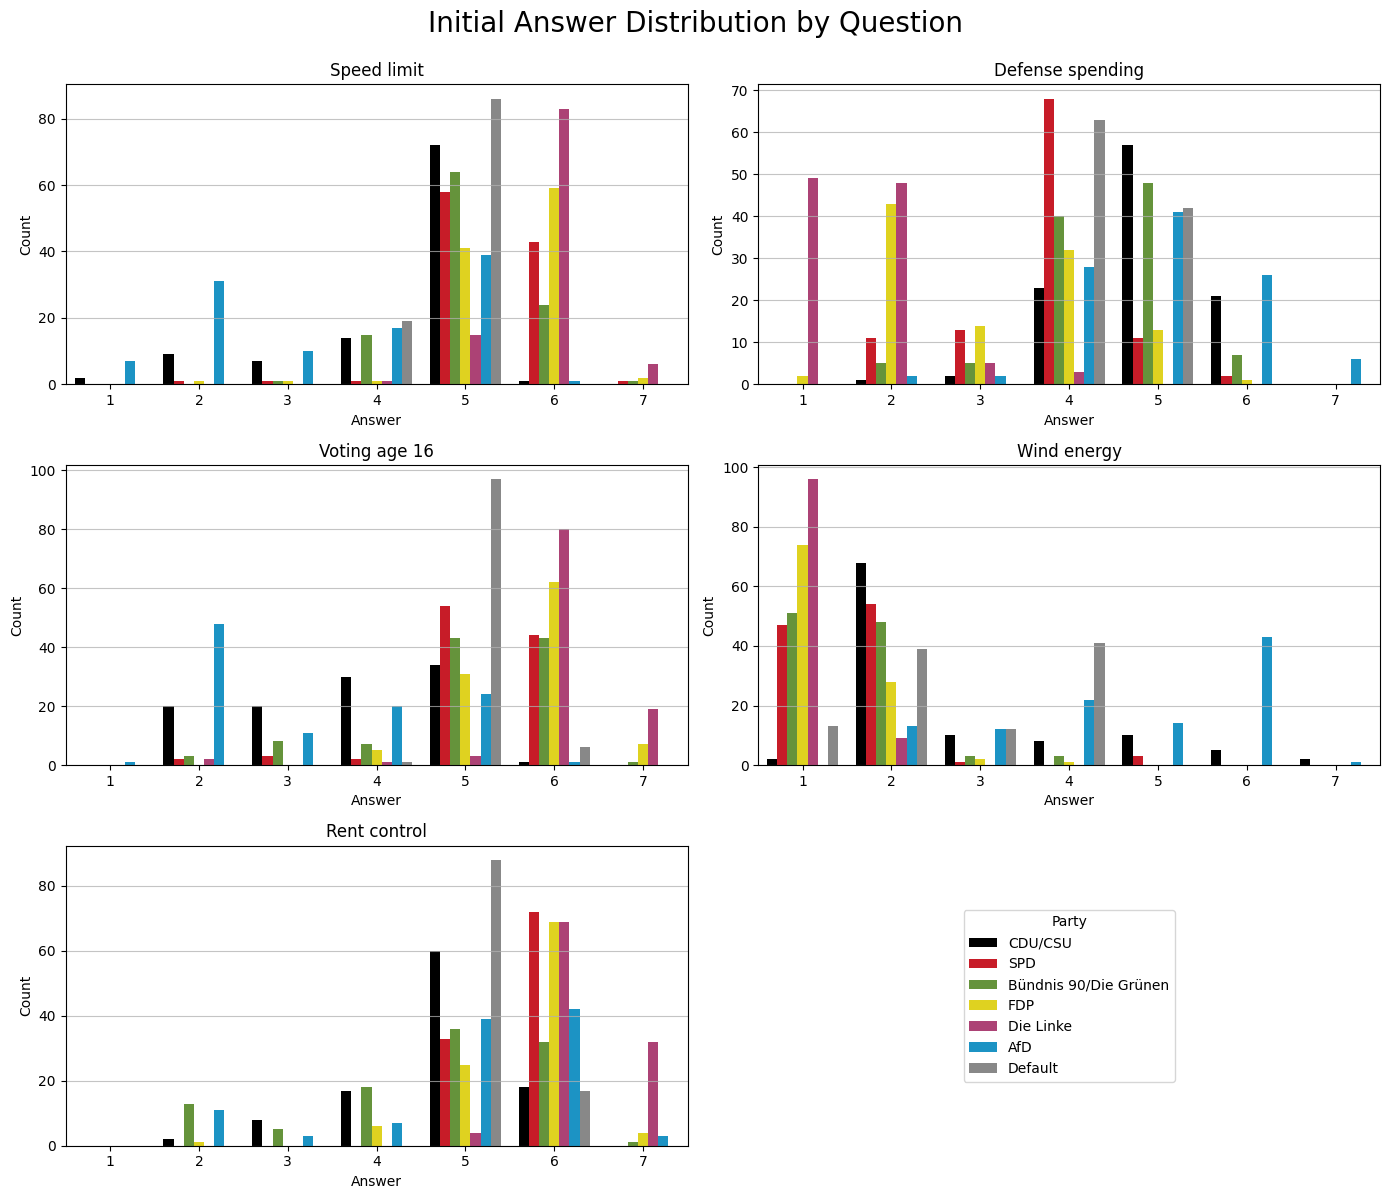

In [46]:
import seaborn as sns

# Color mapping for parties
party_palette = {
    "CDU/CSU": "#000000",  # Black
    "SPD": "#E3000F",      # Red
    "Bündnis 90/Die Grünen": "#64A12D",  # Green
    "FDP": "#FFED00",      # Yellow
    "Die Linke": "#BE3075", # Dark Pink
    "AfD": "#009EE0",      # Blue
    "Default": "#888888", # Gray
}

fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, question_idx in enumerate(range(5)):
    q_df = plot_df[
        (plot_df["question_index"] == question_idx) & (plot_df['time'] == 0)
    ].copy()
    
    q_df['answer'] = q_df['answer'].astype(int)
    
    sns.countplot(
        data=q_df,
        x="answer",
        hue="party",
        palette=party_palette,
        dodge=True,
        hue_order=["CDU/CSU", "SPD", "Bündnis 90/Die Grünen", "FDP", "Die Linke", "AfD", "Default"],
        order=list(range(1, 8)),
        ax=axes[idx],
    )
    
    
    axes[idx].set_title(f"{QUESTIONS_SHORT_EN[question_idx]}", fontsize=12)
    axes[idx].set_xlabel("Answer")
    axes[idx].set_ylabel("Count")
    axes[idx].grid(axis="y", alpha=0.75)
    axes[idx].get_legend().remove()

# Hide the last unused subplot

if n_questions < len(axes):
    legend_ax = axes[n_questions]
    legend_ax.axis("off")  # hide axis
    handles, labels = axes[0].get_legend_handles_labels()
    legend_ax.legend(handles, labels, title="Party", loc="center")


for ax in axes[n_questions+1:]:
    ax.set_visible(False)

fig.suptitle(f"Initial Answer Distribution by Question", fontsize=20, y=0.995)
plt.tight_layout()
plt.savefig(f"figures/answer_count_distribution_all_q_{LLM_VERSION}.pdf")
plt.show()

In [47]:
# LMM - Linearly Mixed Model
# Model: answer ~ iteration + party + version, random intercept for agent_idx within party


# Prepare the main dataframe for LMM once, outside the loop
lmm_data = party_df_non_abs.copy()
lmm_data['version'] = lmm_data['version'].astype('category')
lmm_data = lmm_data.dropna(subset=["answer"]).reset_index(drop=True)
lmm_data["answer"] = pd.to_numeric(lmm_data["answer"], errors="coerce")
# map from 0,4,8,12,16,20 to 0,1,2,3,4,5
lmm_data["time"] = lmm_data["time"].str.replace("T", "").astype(int)
lmm_data["time"] = lmm_data["time"].apply(
    lambda x: x / 4 if pd.notna(x) else np.nan
)
lmm_data["time"] = pd.to_numeric(lmm_data["time"], errors="coerce")
lmm_data["question_index"] = lmm_data["question_index"].astype("category")
lmm_data["party"] = lmm_data["party"].astype("category")
lmm_data["party"] = lmm_data["party"].cat.reorder_categories(
    ["Default", "AfD", "Bündnis 90/Die Grünen", "CDU/CSU", "Die Linke", "FDP", "SPD"],
    ordered=False
)
lmm_data["debate_with"] = lmm_data["debate_with"].astype("category")
lmm_data = lmm_data.reset_index(drop=True)


display(lmm_data)

,party,debate_with,version,question_index,repetition,time,answer
0,CDU/CSU,AfD,0.0,0.0,0,0.0,5.0
1,AfD,CDU/CSU,0.0,0.0,0,0.0,2.0
2,CDU/CSU,AfD,0.0,0.0,1,0.0,3.0
3,AfD,CDU/CSU,0.0,0.0,1,0.0,5.0
4,CDU/CSU,AfD,0.0,0.0,2,0.0,5.0
...,...,...,...,...,...,...,...
22002,CDU/CSU,FDP,2.0,4.0,2,5.0,5.0
22003,FDP,CDU/CSU,2.0,4.0,3,5.0,6.0
22004,CDU/CSU,FDP,2.0,4.0,3,5.0,5.0
22005,FDP,CDU/CSU,2.0,4.0,4,5.0,5.0


# Effect Size via R^2 # Likelyhood test 

In [48]:
# calculate r^2 for the model always missing a fixed effect

full_model = smf.mixedlm(
    "answer ~ time * question_index + party * question_index + version * question_index",
    lmm_data,
    groups=lmm_data["repetition"].astype(str),
    re_formula="~ time" 
).fit(reml=False)  

no_party_model = smf.mixedlm(
    "answer ~ time * question_index + version * question_index",
    lmm_data,
    groups=lmm_data["repetition"].astype(str),
    re_formula="~ time" 
).fit(reml=False)

no_version_model = smf.mixedlm(
    "answer ~ time * question_index + party * question_index",
    lmm_data,
    groups=lmm_data["repetition"].astype(str),
    re_formula="~ time" 
).fit(reml=False)

no_time_model = smf.mixedlm(
    "answer ~ question_index * party  + question_index * version",
    lmm_data,
    groups=lmm_data["repetition"].astype(str),
    re_formula="~ time"
).fit(reml=False)

no_question_model = smf.mixedlm(
    "answer ~ time + party + version",
    lmm_data,
    groups=lmm_data["repetition"].astype(str),
    re_formula="~ time"
).fit(reml=False)


r2_full = r2_score(full_model.fittedvalues, lmm_data["answer"])

r2_no_party = r2_score(no_party_model.fittedvalues, lmm_data["answer"])

r2_no_version = r2_score(no_version_model.fittedvalues, lmm_data["answer"])

r2_no_time = r2_score(no_time_model.fittedvalues, lmm_data["answer"])

r2_no_question = r2_score(no_question_model.fittedvalues, lmm_data["answer"])

print(f"R^2 for full model: {r2_full:.4f}")
print(f"R^2 loss without party: {r2_full - r2_no_party:.4f}")
print(f"R^2 loss without version: {r2_full - r2_no_version:.4f}")
print(f"R^2 loss without time: {r2_full - r2_no_time:.4f}")
print(f"R^2 loss without question: {r2_full - r2_no_question:.4f}")


############


# LRT statistic
lr_stat = 2 * (full_model.llf - no_version_model.llf)

# Degrees of freedom = difference in number of parameters
df_diff = full_model.df_modelwc - no_version_model.df_modelwc

# p-value
p_value = stats.chi2.sf(lr_stat, df_diff)

print(f"LRT statistic: {lr_stat:.2f}")
print(f"df difference: {df_diff}")
print(f"p-value: {p_value:.4f}")

/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_l

R^2 for full model: 0.5688
R^2 loss without party: 0.3997
R^2 loss without version: 0.0197
R^2 loss without time: 0.0056
R^2 loss without question: 155.1341
LRT statistic: 681.95
df difference: 10
p-value: 0.0000


/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


# Do agents with strong party affiliation align with their party’s official stance?

In [49]:
# Do agents with strong party affiliation align with their party’s official stance?

print(parties)
print(QUESTIONS)
# table of parties x questions with party opinions, hardcoded
# since questions are from the Wahl-O-Mat they can have true/false/neutral

NEG = "Negative"
POS = "Positive"
NEU = "Neutral"




party_opinions = {
    "CDU/CSU": [False, True, False, False, None],
    "AfD": [False, True, False, True, False],
    'Bündnis 90/Die Grünen': [True, False, True, False, True],
    "Die Linke": [True, False, True, False, True],
    "FDP": [False, True, True, None, False],
    "SPD": [True, True, True, False, True],
    "keine Partei": [None, None, None, None, None]
}

party_opinions = {
    "CDU/CSU": [NEG, POS, NEG, NEG, NEU],
    "AfD": [NEG, POS, NEG, POS, NEG],
    'Bündnis 90/Die Grünen': [POS, NEG, POS, NEG, POS],
    "Die Linke": [POS, NEG, POS, NEG, POS],
    "FDP": [NEG, POS, POS, NEU, NEG],
    "SPD": [POS, POS, POS, NEG, POS],
    "keine Partei": [NEU, NEU, NEU, NEU, NEU]
}



initial_opinions = lmm_data[lmm_data["time"] == 0][["party", "question_index", "answer"]].copy()

fdp_data = initial_opinions[initial_opinions["party"] == "FDP"]

fdp_means = fdp_data.groupby("question_index")["answer"].mean().reset_index()
print("FDP initial opinions means:")
print(fdp_means)
print("FDP initial opinions counts:")
print(party_opinions["FDP"])

# map answers to True/False/Neutral
# answers 1-3 -> False, 4 -> Neutral, 5-7 -> True
def map_answer_to_opinion(answer):
    if answer <= 3:
        return NEG
    elif answer == 4:
        return NEU
    elif answer >= 5:
        return POS
    else:
        return NEU
initial_opinions["mapped_answer"] = initial_opinions["answer"].apply(map_answer_to_opinion) 


# calculate the alignment with party opinion # where d(True, True) = 0 and d(False, False) = 0, d(True, False) = 1, d(True, None) = 0.5
def calculate_distance(row):
    party = row["party"]
    question_index = int(row["question_index"])
    mapped_answer = row["mapped_answer"]
    party_opinion = party_opinions.get(party, [None]*5)[question_index]
    if party_opinion == mapped_answer:
        return 0  # Aligned
    elif party_opinion == NEG and mapped_answer == POS:
        return 1  # Opposed
    elif party_opinion == POS and mapped_answer == NEG:
        return 1  # Opposed
    else:
        return 0.5  # Neutral or no opinion


# calculate the allignment for each party and question
initial_opinions["alignment"] = initial_opinions.apply(calculate_distance, axis=1)


# average alignment per party 
average_distance = initial_opinions.groupby("party")["alignment"].mean().reset_index()
average_distance = average_distance.sort_values(by="alignment")
print(average_distance)

def get_party_opinion(row):
    party = row["party"]
    q_index = int(row["question_index"])
    # Ensure the question index is valid for the party_opinions list
    if party in party_opinions and q_index < len(party_opinions[party]):
        return party_opinions[party][q_index]
    return None

initial_opinions["party_opinion"] = initial_opinions.apply(get_party_opinion, axis=1)


# Step 2: Convert boolean/None opinions to a numerical scale for correlation
def opinion_to_numeric(opinion):
    if opinion is POS:
        return 1
    elif opinion is NEG:
        return -1
    else: # This covers None (Neutral)
        return 0

initial_opinions["user_opinion_numeric"] = initial_opinions["mapped_answer"].apply(opinion_to_numeric)
initial_opinions["party_opinion_numeric"] = initial_opinions["party_opinion"].apply(opinion_to_numeric)


# Step 3: Group by party and calculate Spearman's correlation
# We calculate the correlation between the numeric user opinion and the numeric party opinion.
spearman_corr = initial_opinions.groupby("party")[["user_opinion_numeric", "party_opinion_numeric"]].corr(method="spearman")

# The result is a multi-index DataFrame. We can simplify it for a clearer view.
# We only need the correlation value between the two different columns.
rho_values = spearman_corr.unstack().iloc[:, 1]

# Sort the results to see which party has the highest correlation
rho_values_sorted = rho_values.sort_values(ascending=False).reset_index()
rho_values_sorted.columns = ["party", "spearman_rho"]


print("--- Spearman's Rank Correlation (rho) per Party ---")
print(rho_values_sorted)


final_opinions = lmm_data[lmm_data["time"] == 5][["party", "question_index", "answer"]].copy()
final_opinions["mapped_answer"] = final_opinions["answer"].apply(map_answer_to_opinion)
final_opinions["alignment"] = final_opinions.apply(calculate_distance, axis=1)
final_average_distance = final_opinions.groupby("party")["alignment"].mean().reset_index()
final_average_distance = final_average_distance.sort_values(by="alignment")
print("--- Final Opinions Average Alignment ---")
print(final_average_distance)
final_opinions["party_opinion"] = final_opinions.apply(get_party_opinion, axis=1)
final_opinions["user_opinion_numeric"] = final_opinions["mapped_answer"].apply(opinion_to_numeric)
final_opinions["party_opinion_numeric"] = final_opinions["party_opinion"].apply(opinion_to_numeric)
final_spearman_corr = final_opinions.groupby("party")[["user_opinion_numeric", "party_opinion_numeric"]].corr(method="spearman")
final_rho_values = final_spearman_corr.unstack().iloc[:, 1]
final_rho_values_sorted = final_rho_values.sort_values(ascending=False).reset_index()
final_rho_values_sorted.columns = ["party", "spearman_rho"]
print("--- Final Opinions Spearman's Rank Correlation (rho) per Party ---")
print(final_rho_values_sorted)


/var/folders/7m/xjp08lvs2dg885vy_yybj_2r0000gn/T/ipykernel_5672/76239207.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fdp_means = fdp_data.groupby("question_index")["answer"].mean().reset_index()
/var/folders/7m/xjp08lvs2dg885vy_yybj_2r0000gn/T/ipykernel_5672/76239207.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_distance = initial_opinions.groupby("party")["alignment"].mean().reset_index()
/var/folders/7m/xjp08lvs2dg885vy_yybj_2r0000gn/T/ipykernel_5672/76239207.py:112: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. 

['CDU/CSU', 'AfD', 'Bündnis 90/Die Grünen', 'Die Linke', 'FDP', 'SPD', 'Default']
['Auf allen Deutschen Autobahnen soll es ein generelles Tempolimit geben', 'Deutschland soll seine Verteidigungsausgaben erhöhen', 'Bei Bundestagswahlen sollen auch Jugendliche ab 16 Jahren wählen dürfen.', 'Die Förderung von Windenergie soll beendet werden.', 'Die Möglichkeiten der Vermieterinnen und Vermieter, Wohnungsmieten zu erhöhen, sollen gesetzlich stärker begrenzt werden.']
FDP initial opinions means:
  question_index    answer
0            0.0  5.542857
1            1.0  3.133333
2            2.0  5.676190
3            3.0  1.333333
4            4.0  5.647619
FDP initial opinions counts:
['Negative', 'Positive', 'Positive', 'Neutral', 'Negative']
                   party  alignment
4              Die Linke   0.008571
6                    SPD   0.132381
2  Bündnis 90/Die Grünen   0.240952
3                CDU/CSU   0.399809
1                    AfD   0.428571
0                Default   0.500000
5

--- Average Answers per Question per Time Step ---
plotting 2 for $CDU/CSU at question 0
plotting 2 for $AfD at question 0
plotting 6 for $Bündnis 90/Die Grünen at question 0
plotting 6 for $Die Linke at question 0
plotting 2 for $FDP at question 0
plotting 6 for $SPD at question 0


/var/folders/7m/xjp08lvs2dg885vy_yybj_2r0000gn/T/ipykernel_5672/259962329.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_answers = lmm_data.groupby(["question_index", "time"])["answer"].mean().reset_index()
/var/folders/7m/xjp08lvs2dg885vy_yybj_2r0000gn/T/ipykernel_5672/259962329.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats_df = lmm_data.groupby(["question_index", "time"])["answer"].agg(["mean", "std", "count"]).reset_index()


plotting 6 for $CDU/CSU at question 1
plotting 6 for $AfD at question 1
plotting 2 for $Bündnis 90/Die Grünen at question 1
plotting 2 for $Die Linke at question 1
plotting 6 for $FDP at question 1
plotting 6 for $SPD at question 1
plotting 2 for $CDU/CSU at question 2
plotting 2 for $AfD at question 2
plotting 6 for $Bündnis 90/Die Grünen at question 2
plotting 6 for $Die Linke at question 2
plotting 6 for $FDP at question 2
plotting 6 for $SPD at question 2
plotting 2 for $CDU/CSU at question 3
plotting 6 for $AfD at question 3
plotting 2 for $Bündnis 90/Die Grünen at question 3
plotting 2 for $Die Linke at question 3
plotting 4 for $FDP at question 3
plotting 2 for $SPD at question 3
plotting 4 for $CDU/CSU at question 4
plotting 2 for $AfD at question 4
plotting 6 for $Bündnis 90/Die Grünen at question 4
plotting 6 for $Die Linke at question 4
plotting 2 for $FDP at question 4
plotting 6 for $SPD at question 4


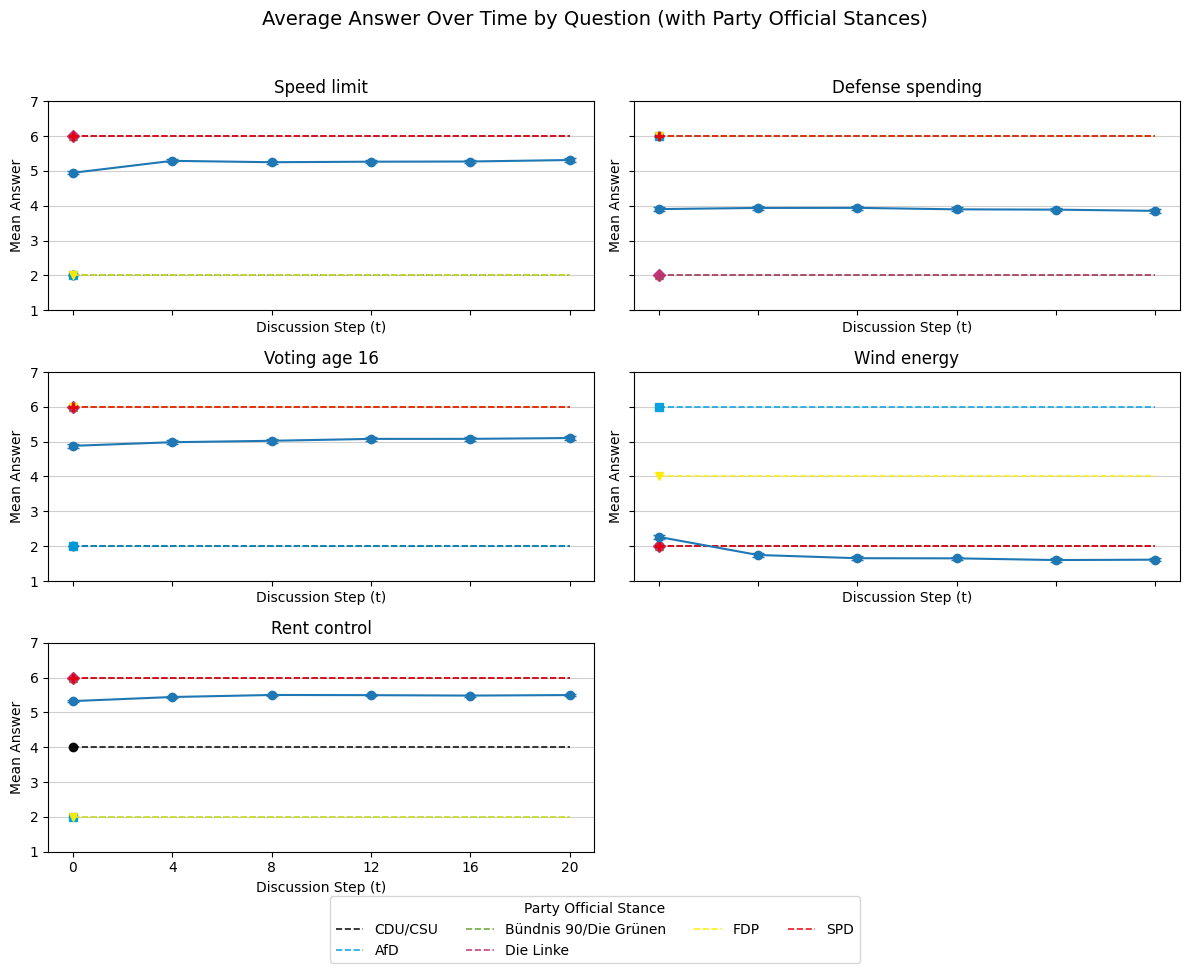

In [50]:
# calculate average answer per question per time step
avg_answers = lmm_data.groupby(["question_index", "time"])["answer"].mean().reset_index()
avg_answers.columns = ["question_index", "time", "avg_answer"]
print("--- Average Answers per Question per Time Step ---")

# Ensure we have a numeric mapping for party official stances
party_opinions_values = {
    "CDU/CSU": [2, 6, 2, 2, 4],
    "AfD": [2, 6, 2, 6, 2],
    "Bündnis 90/Die Grünen": [6, 2, 6, 2, 6],
    "Die Linke": [6, 2, 6, 2, 6],
    "FDP": [2, 6, 6, 4, 2],
    "SPD": [6, 6, 6, 2, 6],
}

markers = ['o', 's', '^', 'D', 'v', 'P', '*']

# 3x2 subplot for average answers over time per question, with party opinions drawn
fig, axes = plt.subplots(3, 2, figsize=(12, 10), sharex=True, sharey=True)
axes = axes.flatten()

# compute mean and stderr per question/time
stats_df = lmm_data.groupby(["question_index", "time"])["answer"].agg(["mean", "std", "count"]).reset_index()
stats_df["sem"] = stats_df["std"] / np.sqrt(stats_df["count"])

questions = sorted(lmm_data["question_index"].unique())

# collect legend handles for party opinion lines (only once)
party_handles = []
party_labels = []
plotted_parties = set()

for ax_idx, q in enumerate(questions):
    ax = axes[ax_idx]
    q_stats = stats_df[stats_df["question_index"] == q].sort_values("time")
    x_vals = q_stats["time"] * 4  # map 0..5 back to 0,4,8,...,20
    y_vals = q_stats["mean"]
    yerr = q_stats["sem"]

    ax.errorbar(x_vals, y_vals, yerr=yerr, marker="o", capsize=4, linestyle="-", color="tab:blue")
    ax.set_title(f"{QUESTIONS_SHORT_EN[int(q)]}")
    ax.set_xticks([0, 4, 8, 12, 16, 20])
    ax.set_ylim(1, 7)
    ax.set_xlabel("Discussion Step (t)")
    ax.set_ylabel("Mean Answer")
    ax.grid(axis="y", alpha=0.6)

    # Plot party official stances as horizontal lines
    for i, party in enumerate(party_opinions_values):
        y_line = party_opinions_values[party][ax_idx]
        color = party_palette.get(party, party_palette["Default"])
        marker = markers[i % len(markers)]

        # draw horizontal line for party stance across the full x-range
        h = ax.hlines(y_line, xmin=0, xmax=20, colors=color, linestyles="--", linewidth=1.2, alpha=0.9)
        # add a marker at the left edge to make the party more visible
        ax.plot(0, y_line, marker=marker, color=color, markersize=6, linestyle="None", alpha=0.95)

        print(f"plotting {y_line} for ${party} at question {ax_idx}")

        # collect a handle/label only once for the legend
        if party not in plotted_parties:
            party_handles.append(h)
            party_labels.append(party)
            plotted_parties.add(party)

# hide any unused axes
for ax in axes[len(questions):]:
    ax.set_visible(False)

plt.suptitle("Average Answer Over Time by Question (with Party Official Stances)", fontsize=14)

# add a legend for party official stances outside the plot
if party_handles:
    legend_handles = []
    for h in party_handles:
        if isinstance(h, (list, tuple, np.ndarray)):
            legend_handles.append(h[0])
        else:
            legend_handles.append(h)
    fig.legend(legend_handles, party_labels, title="Party Official Stance", loc="lower center", ncol=4, bbox_to_anchor=(0.5, 0.02))

plt.tight_layout(rect=[0, 0.08, 1, 0.96])
plt.savefig(f"figures/average_answer_over_time_{LLM_VERSION}.pdf")
plt.show()

In [51]:
# same but whith Cohens Kappa

from sklearn.metrics import cohen_kappa_score
# Calculate Cohen's Kappa for each party
initial_opinions["user_opinion_str"] = initial_opinions["mapped_answer"].apply(lambda x: str(x))
initial_opinions["party_opinion_str"] = initial_opinions["party_opinion"].apply(lambda x: str(x))

kappa_values = {}
for prompts, group in initial_opinions.groupby("party"):
    if len(group["user_opinion_str"].unique()) > 1 and len(group["party_opinion_str"].unique()) > 1:
        kappa = cohen_kappa_score(group["user_opinion_str"], group["party_opinion_str"])
        kappa_values[prompts] = kappa
    else:
        kappa_values[prompts] = None  # Not enough variation to compute Kappa
kappa_df = pd.DataFrame(list(kappa_values.items()), columns=["party", "cohen_kappa"])
kappa_df = kappa_df.sort_values(by="cohen_kappa", ascending=False)
print("--- Cohen's Kappa per Party ---")
print(kappa_df)


--- Cohen's Kappa per Party ---
                   party  cohen_kappa
4              Die Linke     0.972527
6                    SPD     0.565397
2  Bündnis 90/Die Grünen     0.417071
3                CDU/CSU     0.189462
1                    AfD     0.156328
5                    FDP    -0.256173
0                Default          NaN


/var/folders/7m/xjp08lvs2dg885vy_yybj_2r0000gn/T/ipykernel_5672/4078395203.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for prompts, group in initial_opinions.groupby("party"):


# Distance from Initial Opinion 
In the following I'll be answering RQ2: "Does discussion cause agents' opinions to significantly shift from their starting points and converge towards more uniform stances?" by calculting the distance from the original opinion


In [52]:
lmm_data

,party,debate_with,version,question_index,repetition,time,answer
0,CDU/CSU,AfD,0.0,0.0,0,0.0,5.0
1,AfD,CDU/CSU,0.0,0.0,0,0.0,2.0
2,CDU/CSU,AfD,0.0,0.0,1,0.0,3.0
3,AfD,CDU/CSU,0.0,0.0,1,0.0,5.0
4,CDU/CSU,AfD,0.0,0.0,2,0.0,5.0
...,...,...,...,...,...,...,...
22002,CDU/CSU,FDP,2.0,4.0,2,5.0,5.0
22003,FDP,CDU/CSU,2.0,4.0,3,5.0,6.0
22004,CDU/CSU,FDP,2.0,4.0,3,5.0,5.0
22005,FDP,CDU/CSU,2.0,4.0,4,5.0,5.0


In [53]:
display(formatted_df)
bla = formatted_df.copy()


# show all columns with na values
display(bla.isna().sum())
# show row where T0 is na
display(bla[bla["T0"].isna()])


# remove rows with missing values
bla = bla.dropna(axis=0, how='any')

display(bla)

# Calculate distance from initial opinion for each timepoint
for t in ["T0", "T4", "T8", "T12", "T16", "T20"]:
    bla[f"d{t[1:]}"] = abs(bla[t] - bla["T0"])

# Optionally, also include d0 (which is always zero)
#bla["d0"] = 0
display(bla)


,party,debate_with,repetition,question_index,version,T0,T4,T8,T12,T16,T20
0,CDU/CSU,AfD,0,0.0,0.0,5.0,5.0,5.0,5.0,5.0,5.0
1,AfD,CDU/CSU,0,0.0,0.0,2.0,5.0,5.0,5.0,5.0,5.0
2,CDU/CSU,AfD,1,0.0,0.0,3.0,4.0,5.0,6.0,6.0,5.0
3,AfD,CDU/CSU,1,0.0,0.0,5.0,5.0,5.0,6.0,5.0,5.0
4,CDU/CSU,AfD,2,0.0,0.0,5.0,5.0,5.0,5.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...
3670,CDU/CSU,FDP,2,4.0,2.0,5.0,4.0,4.0,4.0,4.0,5.0
3671,FDP,CDU/CSU,3,4.0,2.0,6.0,5.0,5.0,6.0,6.0,6.0
3672,CDU/CSU,FDP,3,4.0,2.0,5.0,4.0,4.0,4.0,5.0,5.0
3673,FDP,CDU/CSU,4,4.0,2.0,5.0,6.0,5.0,6.0,5.0,5.0


party              0
debate_with        0
repetition         0
question_index     0
version            0
T0                 2
T4                 2
T8                 5
T12                9
T16               10
T20               15
dtype: int64

,party,debate_with,repetition,question_index,version,T0,T4,T8,T12,T16,T20
1245,CDU/CSU,Die Linke,2,1.0,1.0,NaN,6.0,6.0,4.0,4.0,4.0
1831,Default,Default,1,2.0,0.0,NaN,6.0,6.0,6.0,6.0,6.0


,party,debate_with,repetition,question_index,version,T0,T4,T8,T12,T16,T20
0,CDU/CSU,AfD,0,0.0,0.0,5.0,5.0,5.0,5.0,5.0,5.0
1,AfD,CDU/CSU,0,0.0,0.0,2.0,5.0,5.0,5.0,5.0,5.0
2,CDU/CSU,AfD,1,0.0,0.0,3.0,4.0,5.0,6.0,6.0,5.0
3,AfD,CDU/CSU,1,0.0,0.0,5.0,5.0,5.0,6.0,5.0,5.0
4,CDU/CSU,AfD,2,0.0,0.0,5.0,5.0,5.0,5.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...
3670,CDU/CSU,FDP,2,4.0,2.0,5.0,4.0,4.0,4.0,4.0,5.0
3671,FDP,CDU/CSU,3,4.0,2.0,6.0,5.0,5.0,6.0,6.0,6.0
3672,CDU/CSU,FDP,3,4.0,2.0,5.0,4.0,4.0,4.0,5.0,5.0
3673,FDP,CDU/CSU,4,4.0,2.0,5.0,6.0,5.0,6.0,5.0,5.0


,party,debate_with,repetition,question_index,version,T0,T4,T8,T12,T16,T20,d0,d4,d8,d12,d16,d20
0,CDU/CSU,AfD,0,0.0,0.0,5.0,5.0,5.0,5.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AfD,CDU/CSU,0,0.0,0.0,2.0,5.0,5.0,5.0,5.0,5.0,0.0,3.0,3.0,3.0,3.0,3.0
2,CDU/CSU,AfD,1,0.0,0.0,3.0,4.0,5.0,6.0,6.0,5.0,0.0,1.0,2.0,3.0,3.0,2.0
3,AfD,CDU/CSU,1,0.0,0.0,5.0,5.0,5.0,6.0,5.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0
4,CDU/CSU,AfD,2,0.0,0.0,5.0,5.0,5.0,5.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3670,CDU/CSU,FDP,2,4.0,2.0,5.0,4.0,4.0,4.0,4.0,5.0,0.0,1.0,1.0,1.0,1.0,0.0
3671,FDP,CDU/CSU,3,4.0,2.0,6.0,5.0,5.0,6.0,6.0,6.0,0.0,1.0,1.0,0.0,0.0,0.0
3672,CDU/CSU,FDP,3,4.0,2.0,5.0,4.0,4.0,4.0,5.0,5.0,0.0,1.0,1.0,1.0,0.0,0.0
3673,FDP,CDU/CSU,4,4.0,2.0,5.0,6.0,5.0,6.0,5.0,5.0,0.0,1.0,0.0,1.0,0.0,0.0


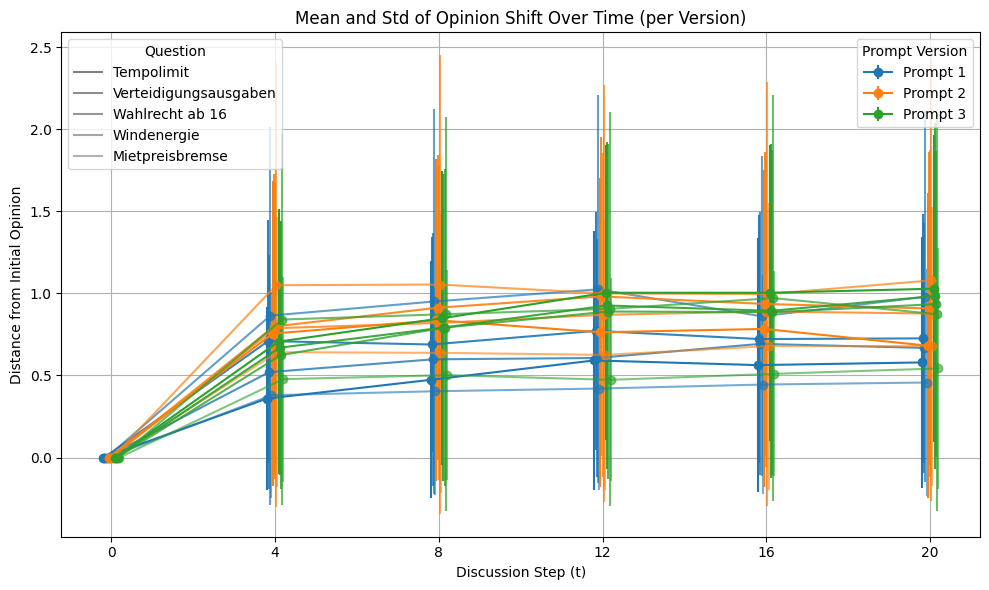

In [54]:
timepoints = ["d0", "d4", "d8", "d12", "d16", "d20"]
prompt_versions = bla["version"].unique()
offsets = np.linspace(
    -0.2, 0.2, len(prompt_versions) * len(QUESTION_INDICES)
)  # Offset for each version and question index

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]
opaqueness = [1, 0.9, 0.8, 0.7, 0.6]  # Opaqueness for each question index


plt.figure(figsize=(10, 6))
ax = plt.gca()

# Store handles for legends
prompt_handles = []
question_handles = []

for i, version in enumerate(prompt_versions):
    question_counter = 0
    for question_index in bla["question_index"].unique():
        version_data = bla[
            (bla["version"] == version) & (bla["question_index"] == question_index)
        ]
        means = [version_data[tp].mean() for tp in timepoints]
        stds = [version_data[tp].std() for tp in timepoints]

        offset_i = i * len(QUESTION_INDICES) + question_counter

        x_vals = (
            np.array([int(tp[1:]) if tp != "d0" else 0 for tp in timepoints])
            + offsets[int(offset_i)]
        )
        line = ax.errorbar(
            x_vals,
            means,
            yerr=stds,
            marker="o",
            label=f"Prompt {i}",
            color=colors[i],
            alpha=opaqueness[question_counter],
        )
        if question_counter == 0:
            prompt_handles.append(line)
        if i == 0:
            # Dummy lines for question legend
            (dummy,) = ax.plot(
                [],
                [],
                color="gray",
                alpha=opaqueness[question_counter],
                label=f"Question {question_index}",
            )
            question_handles.append(dummy)
        question_counter += 1

plt.xticks([0, 4, 8, 12, 16, 20])
plt.xlabel("Discussion Step (t)")
plt.ylabel("Distance from Initial Opinion")
plt.title("Mean and Std of Opinion Shift Over Time (per Version)")
plt.grid(True)

# First legend: Prompt Version (color)
legend1 = ax.legend(
    prompt_handles,
    [f"Prompt {i + 1}" for i in range(len(prompt_versions))],
    title="Prompt Version",
    loc="upper right",
)
ax.add_artist(legend1)

# Second legend: Question (opaqueness)
legend2 = ax.legend(
    question_handles,
    [QUESTIONS_SHORT[int(q)] for q in bla["question_index"].unique()],
    title="Question",
    loc="upper left",
)

plt.tight_layout()
plt.show()


n_questions < len(axes)


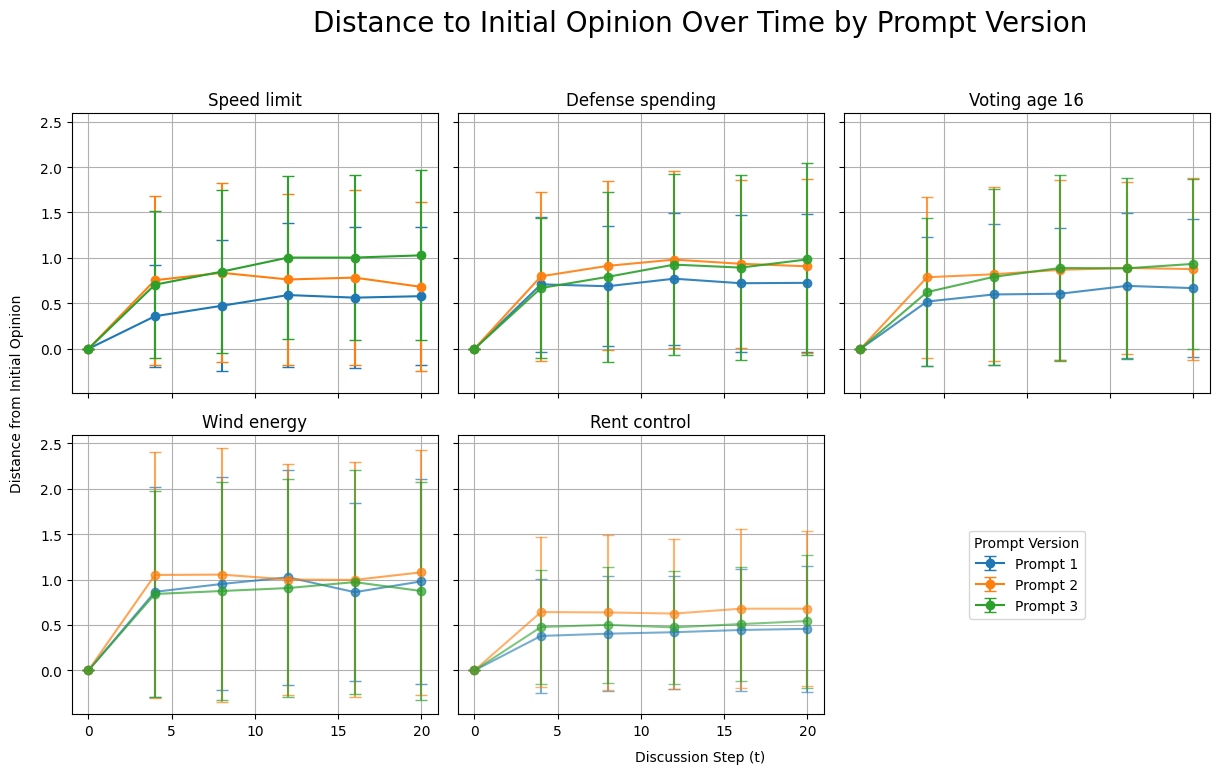

In [55]:
timepoints = ["d0", "d4", "d8", "d12", "d16", "d20"]
prompt_versions = bla["version"].unique()
num_questions = bla["question_index"].nunique()

rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 8), sharex=True, sharey=True)
fig.suptitle("Distance to Initial Opinion Over Time by Prompt Version", fontsize=20)
axes = axes.flatten()

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]
opaqueness = [1, 0.9, 0.8, 0.7, 0.6]  # per question index

prompt_handles = []

for ax, question_index in zip(axes, bla["question_index"].unique()):
    for i, version in enumerate(prompt_versions):
        version_data = bla[
            (bla["version"] == version) & (bla["question_index"] == question_index)
        ]
        means = [version_data[tp].mean() for tp in timepoints]
        stds = [version_data[tp].std() for tp in timepoints]

        x_vals = [int(tp[1:]) if tp != "d0" else 0 for tp in timepoints]

        line = ax.errorbar(
            x_vals,
            means,
            yerr=stds,
            marker="o",
            capsize=4,
            label=f"Prompt {i+1}",
            color=colors[i],
            alpha=opaqueness[int(question_index) % len(opaqueness)],
        )

        if question_index == 0:  # only collect handles once
            prompt_handles.append(line)

    ax.set_title(f"{QUESTIONS_SHORT_EN[int(question_index)]}")
    ax.grid(True)


# Shared labels
fig.text(0.5, 0.04, "Discussion Step (t)", ha="center")
fig.text(0.04, 0.5, "Distance from Initial Opinion", va="center", rotation="vertical")



if n_questions < len(axes):
    print("n_questions < len(axes)")
    legend_ax = axes[n_questions]
    legend_ax.axis("off")  # hide axis
    handles, labels = axes[0].get_legend_handles_labels()
    legend_ax.legend(handles, labels, title="Prompt Version", loc="center")

# Hide unused subplot if fewer than 6
for ax in axes[num_questions+1:]:
    ax.set_visible(False)


# Shared legend: Prompt Versions
# fig.legend(
#     prompt_handles,
#     [f"Prompt {i+1}" for i in range(len(prompt_versions))],
#     title="Prompt Version",
#     loc="upper right"
# )

plt.tight_layout(rect=[0.05, 0.05, 0.85, 0.95])
plt.savefig(f"figures/opinion_shift_per_version_{LLM_VERSION}.pdf")
plt.show()


In [56]:
# flatten the data so instead of having d0, d4, d8, d12, d16, d20 as columns, we have a single column for distance and a column for time
xx = []
for version_label, df in enumerate(bla.groupby("version")):
    version_df = df[1]
    version_df = version_df.melt(
        id_vars=["party", "debate_with", "repetition", "version", "question_index"],
        value_vars=[f"d{t[1:]}" for t in timepoints],
        var_name="time",
        value_name="distance"
    )
    version_df["time"] = version_df["time"].str.replace("d", "").astype(int)
    version_df["version"] = version_label
    xx.append(version_df)
# Concatenate all versions into a single DataFrame

formatted_df_distance = pd.concat(xx, ignore_index=True)

formatted_df_distance

,party,debate_with,repetition,version,question_index,time,distance
0,CDU/CSU,AfD,0,0,0.0,0,0.0
1,AfD,CDU/CSU,0,0,0.0,0,0.0
2,CDU/CSU,AfD,1,0,0.0,0,0.0
3,AfD,CDU/CSU,1,0,0.0,0,0.0
4,CDU/CSU,AfD,2,0,0.0,0,0.0
...,...,...,...,...,...,...,...
21805,CDU/CSU,FDP,2,2,4.0,20,0.0
21806,FDP,CDU/CSU,3,2,4.0,20,0.0
21807,CDU/CSU,FDP,3,2,4.0,20,0.0
21808,FDP,CDU/CSU,4,2,4.0,20,0.0


/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


                                Mixed Linear Model Regression Results
Model:                           MixedLM                Dependent Variable:                distance   
No. Observations:                18175                  Method:                            REML       
No. Groups:                      5                      Scale:                             0.7291     
Min. group size:                 3620                   Log-Likelihood:                    -23018.7899
Max. group size:                 3645                   Converged:                         Yes        
Mean group size:                 3635.0                                                               
------------------------------------------------------------------------------------------------------
                                                           Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------------------
Int

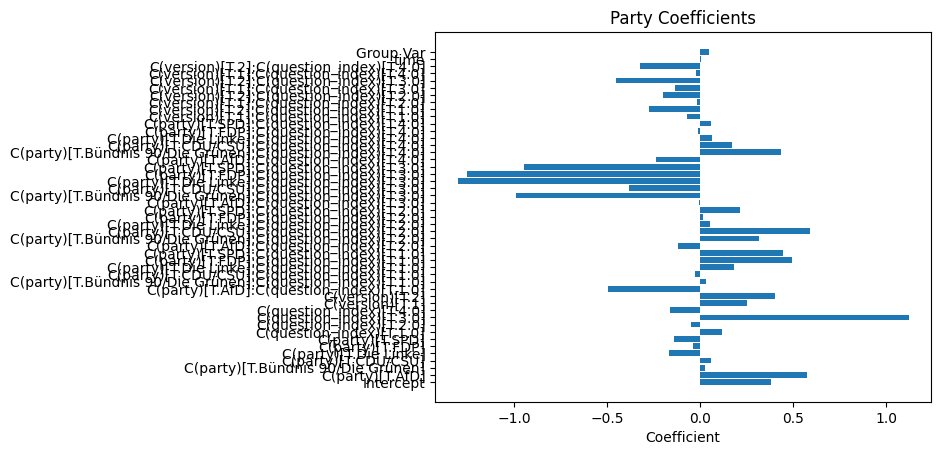

R^2: 0.18778334837736865
0.187780878264279 0.6167949556091618 0.4333397609380676 0.0 0.0028969797381841254
R^2: 0.18778334840986158


In [57]:


formatted_df_distance["party"] = formatted_df_distance["party"].astype("category")
formatted_df_distance["party"] = formatted_df_distance["party"].cat.reorder_categories(
    [
        "Default",
        "AfD",
        "Bündnis 90/Die Grünen",
        "CDU/CSU",
        "Die Linke",
        "FDP",
        "SPD",
    ],
    ordered=False,
)
formatted_df_distance["version"] = formatted_df_distance["version"].astype("category")


formatted_df_distance = formatted_df_distance[
    formatted_df_distance["time"] != 0
]  # Remove d0, as it is always zero




# mixed effects model for distance from initial opinion
groups = formatted_df_distance["repetition"].astype(str)
md = smf.mixedlm(
    "distance ~ time + C(party) * C(question_index) + C(version) * C(question_index)",
    formatted_df_distance,
    groups=groups,
)
mdf = md.fit()
print(mdf.summary())




# get C(party)[T.*] coefficients
party_coefs = mdf.params


# plot all the coefficients

plt.barh(party_coefs.index, party_coefs.values)
plt.xlabel("Coefficient")
plt.title("Party Coefficients")
plt.show()



### calculate R^2 variance


# calculate R^2
r2 = r2_score(formatted_df_distance["distance"], mdf.fittedvalues)
print(f"R^2: {r2}")

slope, intercept, r_value, p_value, std_err = stats.linregress(formatted_df_distance["distance"], mdf.fittedvalues)


print(slope, intercept, r_value, p_value, std_err)
print(f"R^2: {r_value**2}")

# Variance of opinions 

/var/folders/7m/xjp08lvs2dg885vy_yybj_2r0000gn/T/ipykernel_5672/2312822050.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  variance_df = pd.concat(


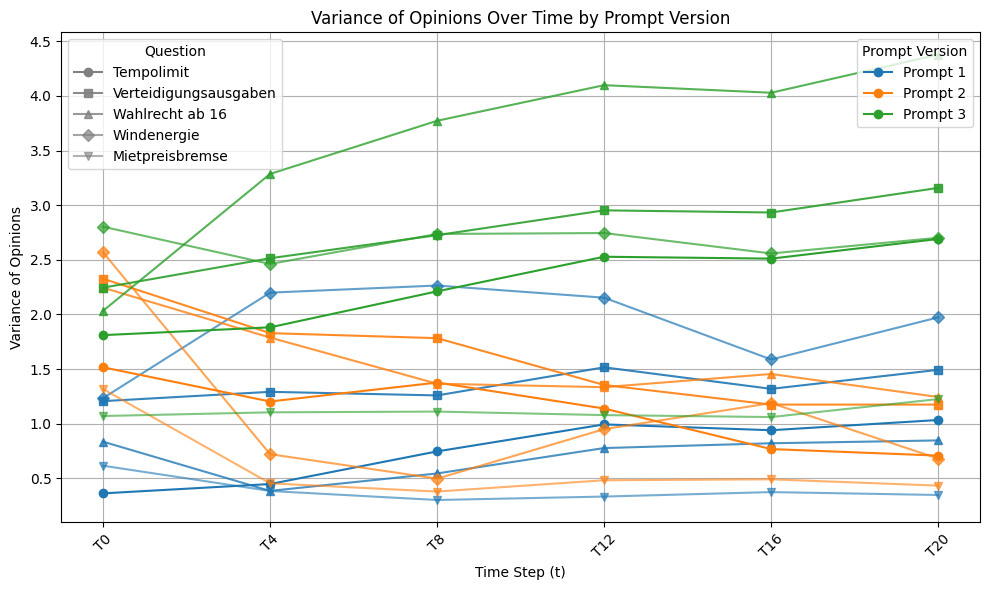

In [58]:
timesteps = [f"T{i}" for i in range(0, 21, 4)]
versions = bla["version"].unique()

variance_df = pd.DataFrame(columns=["version", "time", "variance", "question_index"])

for version in versions:
    for question_index in bla["question_index"].unique():
        for t in timesteps:
            # Filter for current version
            vals = bla[
                (bla["version"] == version) & (bla["question_index"] == question_index)
            ][t]
            variance = vals.var()
            variance_df = pd.concat(
                [
                    variance_df,
                    pd.DataFrame(
                        {
                            "version": [version],
                            "time": [t],
                            "variance": [variance],
                            "question_index": [question_index],
                        }
                    ),
                ],
                ignore_index=True,
            )


plt.figure(figsize=(10, 6))
ax = plt.gca()

# Store handles for legends
prompt_handles = []
question_handles = []
markers = ['o', 's', '^', 'D', 'v', 'P', '*']

for version_idx, version in enumerate(versions):
    for question_cnt, question_index in enumerate(
        variance_df["question_index"].unique()
    ):
        vdf = variance_df[
            (variance_df["version"] == version)
            & (variance_df["question_index"] == question_index)
        ]
        (line,) = ax.plot(
            vdf["time"],
            vdf["variance"],
            marker=markers[question_cnt % len(markers)],
            color=colors[version_idx],
            alpha=opaqueness[question_cnt],
            label=f"Prompt {version_idx} (Q{question_index})",
        )
        if question_cnt == 0:
            prompt_handles.append(line)
        if version_idx == 0:
            # Dummy lines for question legend
            (dummy,) = ax.plot(
                [],
                [],
                color="gray",
                marker=markers[question_cnt % len(markers)],
                alpha=opaqueness[question_cnt],
                label=f"Question {question_index}",
            )
            question_handles.append(dummy)

plt.xticks(timesteps, rotation=45)
plt.xlabel("Time Step (t)")
plt.ylabel("Variance of Opinions")
plt.title("Variance of Opinions Over Time by Prompt Version")

# First legend: Prompt Version (color)
legend1 = ax.legend(
    prompt_handles,
    [f"Prompt {i +1 }" for i in range(len(colors))],
    title="Prompt Version",
    loc="upper right",
)
ax.add_artist(legend1)

# Second legend: Question (opaqueness)
legend2 = ax.legend(
    question_handles,
    [QUESTIONS_SHORT[int(q)] for q in variance_df["question_index"].unique()],
    title="Question",
    loc="upper left",
)

plt.grid(True)
plt.tight_layout()
plt.show()

n_questions < len(axes)


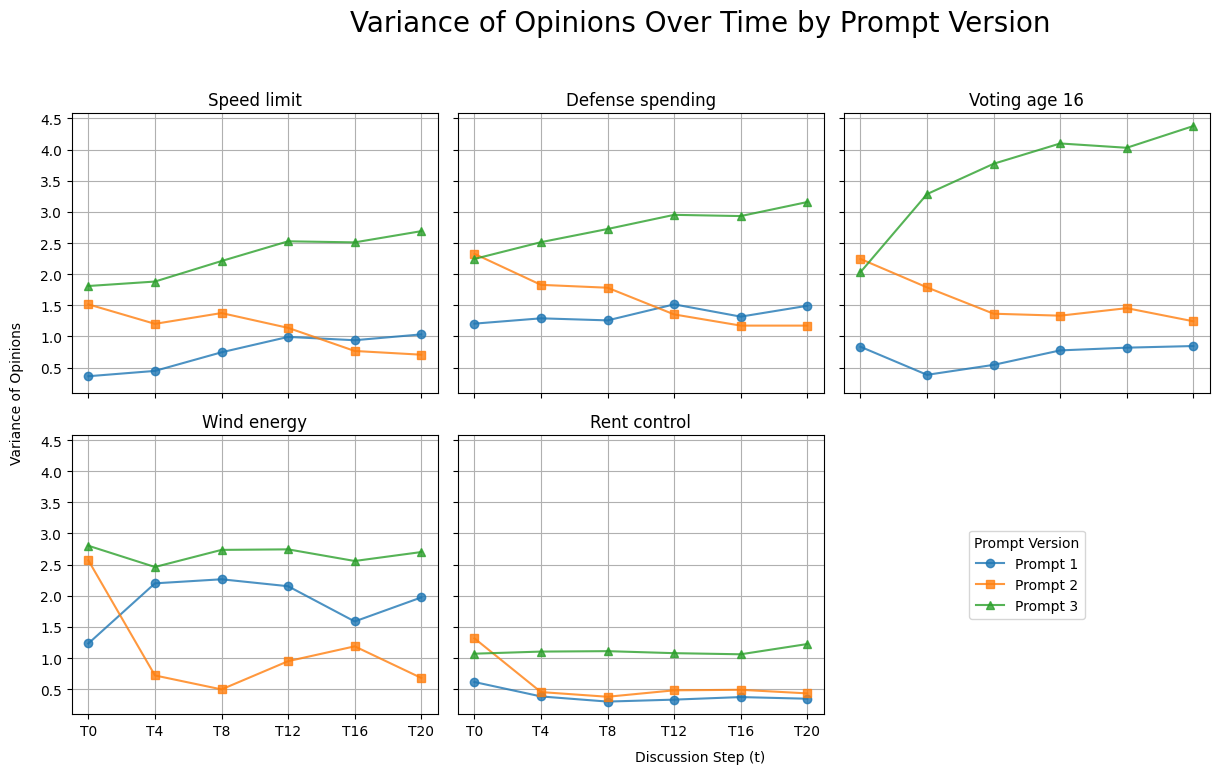

In [59]:
num_questions = variance_df["question_index"].nunique()
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 8), sharex=True, sharey=True)
fig.suptitle("Variance of Opinions Over Time by Prompt Version", fontsize=20)

# Flatten axes for easier indexing
axes = axes.flatten()

markers = ['o', 's', '^', 'D', 'v', 'P', '*']

for ax, question_index in zip(axes, variance_df["question_index"].unique()):
    for version_idx, version in enumerate(versions):
        vdf = variance_df[
            (variance_df["version"] == version)
            & (variance_df["question_index"] == question_index)
        ]
        ax.plot(
            vdf["time"],
            vdf["variance"],
            marker=markers[version_idx % len(markers)],
            color=colors[version_idx],
            alpha=0.8,
            label=f"Prompt {version_idx+1}",
        )

    ax.set_title(f"{QUESTIONS_SHORT_EN[int(question_index)]}")
    ax.grid(True)

# Hide any unused subplot (6th one)
for ax in axes[num_questions:+1]:
    ax.set_visible(False)

# Shared labels
fig.text(0.5, 0.04, "Discussion Step (t)", ha="center")
fig.text(0.04, 0.5, "Variance of Opinions", va="center", rotation="vertical")



if n_questions < len(axes):
    print("n_questions < len(axes)")
    legend_ax = axes[n_questions]
    legend_ax.axis("off")  # hide axis
    handles, labels = axes[0].get_legend_handles_labels()
    legend_ax.legend(handles, labels, title="Prompt Version", loc="center")


# Shared legend outside the grid
# fig.legend(
#     [f"Prompt {i+1}" for i in range(len(versions))],
#     title="Prompt Version",
#     loc="upper right"
# )

plt.tight_layout(rect=[0.05, 0.05, 0.85, 0.95])
plt.savefig(f"figures/variance_over_time_by_prompt_version_{LLM_VERSION}.pdf")
plt.show()


In [67]:
# Ensure 'version' and 'question_index' are categorical for grouping
variance_df["version"] = variance_df["version"].astype("category")
variance_df["question_index"] = variance_df["question_index"].astype("category")

# Fit a mixed effects model: variance ~ time + (1 | version) + (1 | question_index)

if variance_df["time"].dtype == "object":
    variance_df["time"] = variance_df["time"].str.replace("T", "").astype(int)

variance_df["dummy_group"] = 1

vc = {"version": "0 + C(version)", "question_index": "0 + C(question_index)"}

model = smf.mixedlm(
    "variance ~ time",
    data=variance_df,
    groups="dummy_group",
    vc_formula=vc
)

result = model.fit()

print(result.summary())

           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  variance
No. Observations:    90       Method:              REML    
No. Groups:          1        Scale:               0.2926  
Min. group size:     90       Log-Likelihood:      -87.1588
Max. group size:     90       Converged:           Yes     
Mean group size:     90.0                                  
-----------------------------------------------------------
                   Coef. Std.Err.   z   P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept          1.544    0.523 2.952 0.003  0.519  2.569
time               0.002    0.008 0.265 0.791 -0.014  0.019
question_index Var 0.274    0.388                          
version Var        0.626    1.189                          



In [61]:
print(variance_df["time"].dtype)
if variance_df["time"].dtype != "int64":
    variance_df["time"] = variance_df["time"].str.replace("T", "").astype(float)
    variance_df["time"] = variance_df["time"].astype(int)

lm = ols("variance ~ time", data=variance_df, groups=variance_df["version"]).fit()
print(lm.summary())


int64
                            OLS Regression Results                            
Dep. Variable:               variance   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                   0.02176
Date:                Mon, 10 Nov 2025   Prob (F-statistic):              0.883
Time:                        18:05:49   Log-Likelihood:                -124.06
No. Observations:                  90   AIC:                             252.1
Df Residuals:                      88   BIC:                             257.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5439      0.181      8.507   

/Users/lawrencefulton/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['groups']
  warnings.warn(msg, ValueWarning)


In [62]:
for v in variance_df['version'].unique():
    for q in variance_df['question_index'].unique():
        variance_df_subset = variance_df[(variance_df['version'] == v) & (variance_df['question_index'] == q)].copy()
        if variance_df_subset["time"].dtype != "int64":
            variance_df_subset["time"] = variance_df_subset["time"].astype(int)
        
        lm = ols("variance ~ time", data=variance_df_subset).fit()
        print(f"Linear regression summary for version {v} and question {QUESTIONS_SHORT[int(q)]}:")
        print(f"time p = {lm.pvalues['time']:.4f}")
    


Linear regression summary for version 0.0 and question Tempolimit:
time p = 0.0053
Linear regression summary for version 0.0 and question Verteidigungsausgaben:
time p = 0.0907
Linear regression summary for version 0.0 and question Wahlrecht ab 16:
time p = 0.3761
Linear regression summary for version 0.0 and question Windenergie:
time p = 0.6626
Linear regression summary for version 0.0 and question Mietpreisbremse:
time p = 0.1774
Linear regression summary for version 1.0 and question Tempolimit:
time p = 0.0088
Linear regression summary for version 1.0 and question Verteidigungsausgaben:
time p = 0.0027
Linear regression summary for version 1.0 and question Wahlrecht ab 16:
time p = 0.0320
Linear regression summary for version 1.0 and question Windenergie:
time p = 0.2741
Linear regression summary for version 1.0 and question Mietpreisbremse:
time p = 0.1803
Linear regression summary for version 2.0 and question Tempolimit:
time p = 0.0016
Linear regression summary for version 2.0 a